In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import bbknn
import scvelo as scv
import anndata
import leidenalg
import loompy
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib.pyplot import rc_context
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import random

C:\Users\tpsa222\.conda\envs\young\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\tpsa222\.conda\envs\young\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\tpsa222\.conda\envs\young\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

In [2]:
sc.set_figure_params(format='png')  # for beautified visualization
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params(style='scvelo', format='png')  # for beautified visualization

In [3]:
# Set working directory
os.chdir("Y:/Tolulope/Cellranger Results/YYY")

In [4]:
Sham_GFP = 'Y:/Tolulope/Cellranger Results/YYY/YM_Sham_GFP/filtered_feature_bc_matrix'
Sham_noGFP = 'Y:/Tolulope/Cellranger Results/YYY/YM_Sham_noGFP/filtered_feature_bc_matrix'
OV_GFP = 'Y:/Tolulope/Cellranger Results/YYY/YM_OV_GFP/filtered_feature_bc_matrix'
OV_noGFP = 'Y:/Tolulope/Cellranger Results/YYY/YM_OV_noGFP/filtered_feature_bc_matrix'

In [5]:
# Read the 10x Genomics data into AnnData objects
adata1 = sc.read_10x_mtx(Sham_GFP, var_names='gene_symbols', cache=True)
adata2 = sc.read_10x_mtx(Sham_noGFP, var_names='gene_symbols', cache=True)
adata3 = sc.read_10x_mtx(OV_GFP, var_names='gene_symbols', cache=True)
adata4 = sc.read_10x_mtx(OV_noGFP, var_names='gene_symbols', cache=True)

In [6]:
adata1.var_names_make_unique()    # unnecessary if `var_names='gene_ids'`
adata2.var_names_make_unique() 
adata3.var_names_make_unique() 
adata4.var_names_make_unique() 

In [7]:
adata1.raw = adata1
adata2.raw = adata2
adata3.raw = adata3
adata4.raw = adata4

In [8]:
# Quality Control (QC)
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.filter_cells(adata, min_genes=200)
    #sc.pp.filter_genes(adata, min_cells=3)

In [9]:
# Annotate mitochondrial genes
for adata in [adata1, adata2, adata3, adata4]:
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # Assuming mitochondrial genes start with 'MT-'

In [10]:
adata4.var[adata1.var.mt == True]

gene_ids    feature_types    mt
mt-Nd1   ENSMUSG00000064341  Gene Expression  True
mt-Nd2   ENSMUSG00000064345  Gene Expression  True
mt-Co1   ENSMUSG00000064351  Gene Expression  True
mt-Co2   ENSMUSG00000064354  Gene Expression  True
mt-Atp8  ENSMUSG00000064356  Gene Expression  True
mt-Atp6  ENSMUSG00000064357  Gene Expression  True
mt-Co3   ENSMUSG00000064358  Gene Expression  True
mt-Nd3   ENSMUSG00000064360  Gene Expression  True
mt-Nd4l  ENSMUSG00000065947  Gene Expression  True
mt-Nd4   ENSMUSG00000064363  Gene Expression  True
mt-Nd5   ENSMUSG00000064367  Gene Expression  True
mt-Nd6   ENSMUSG00000064368  Gene Expression  True
mt-Cytb  ENSMUSG00000064370  Gene Expression  True

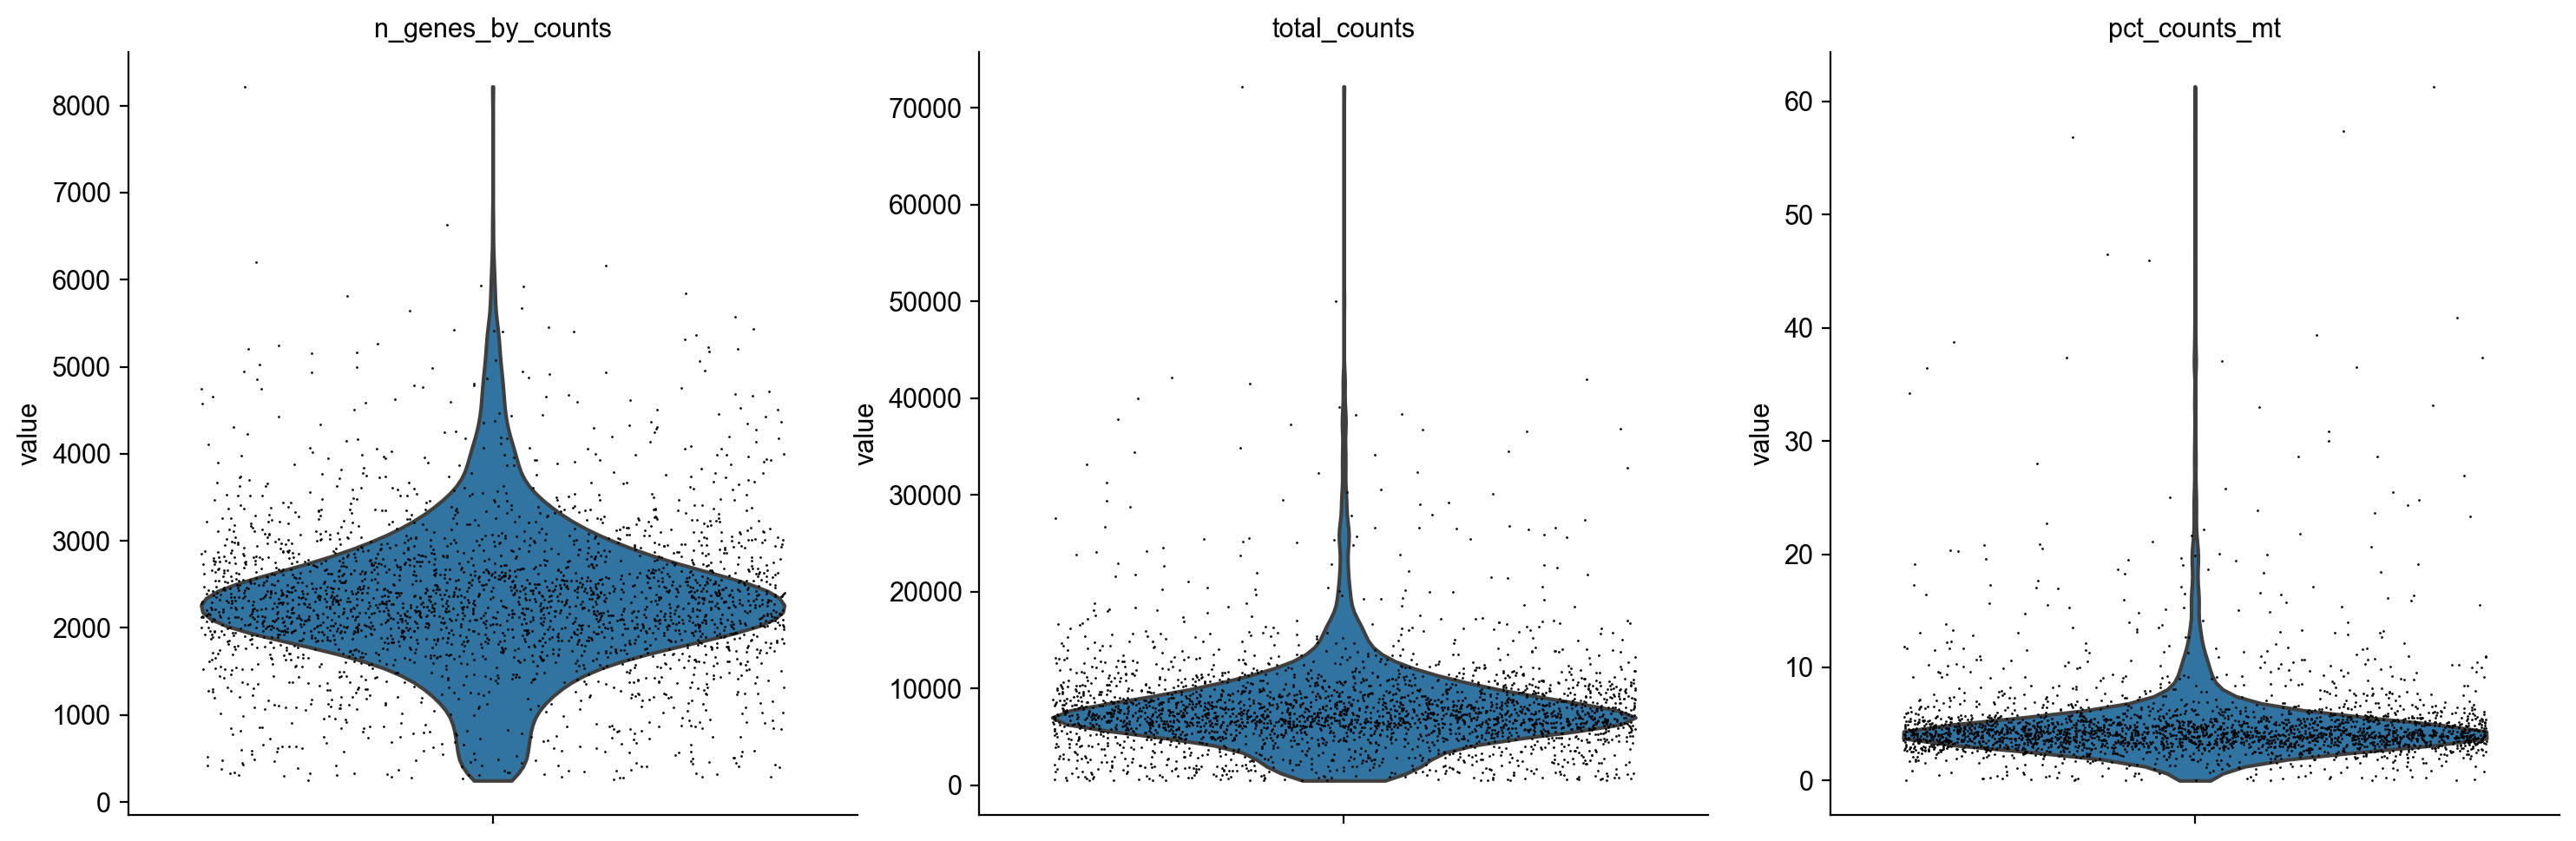

In [11]:
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [12]:

#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata1.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata1.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

484.2 to 4611.9999999999945


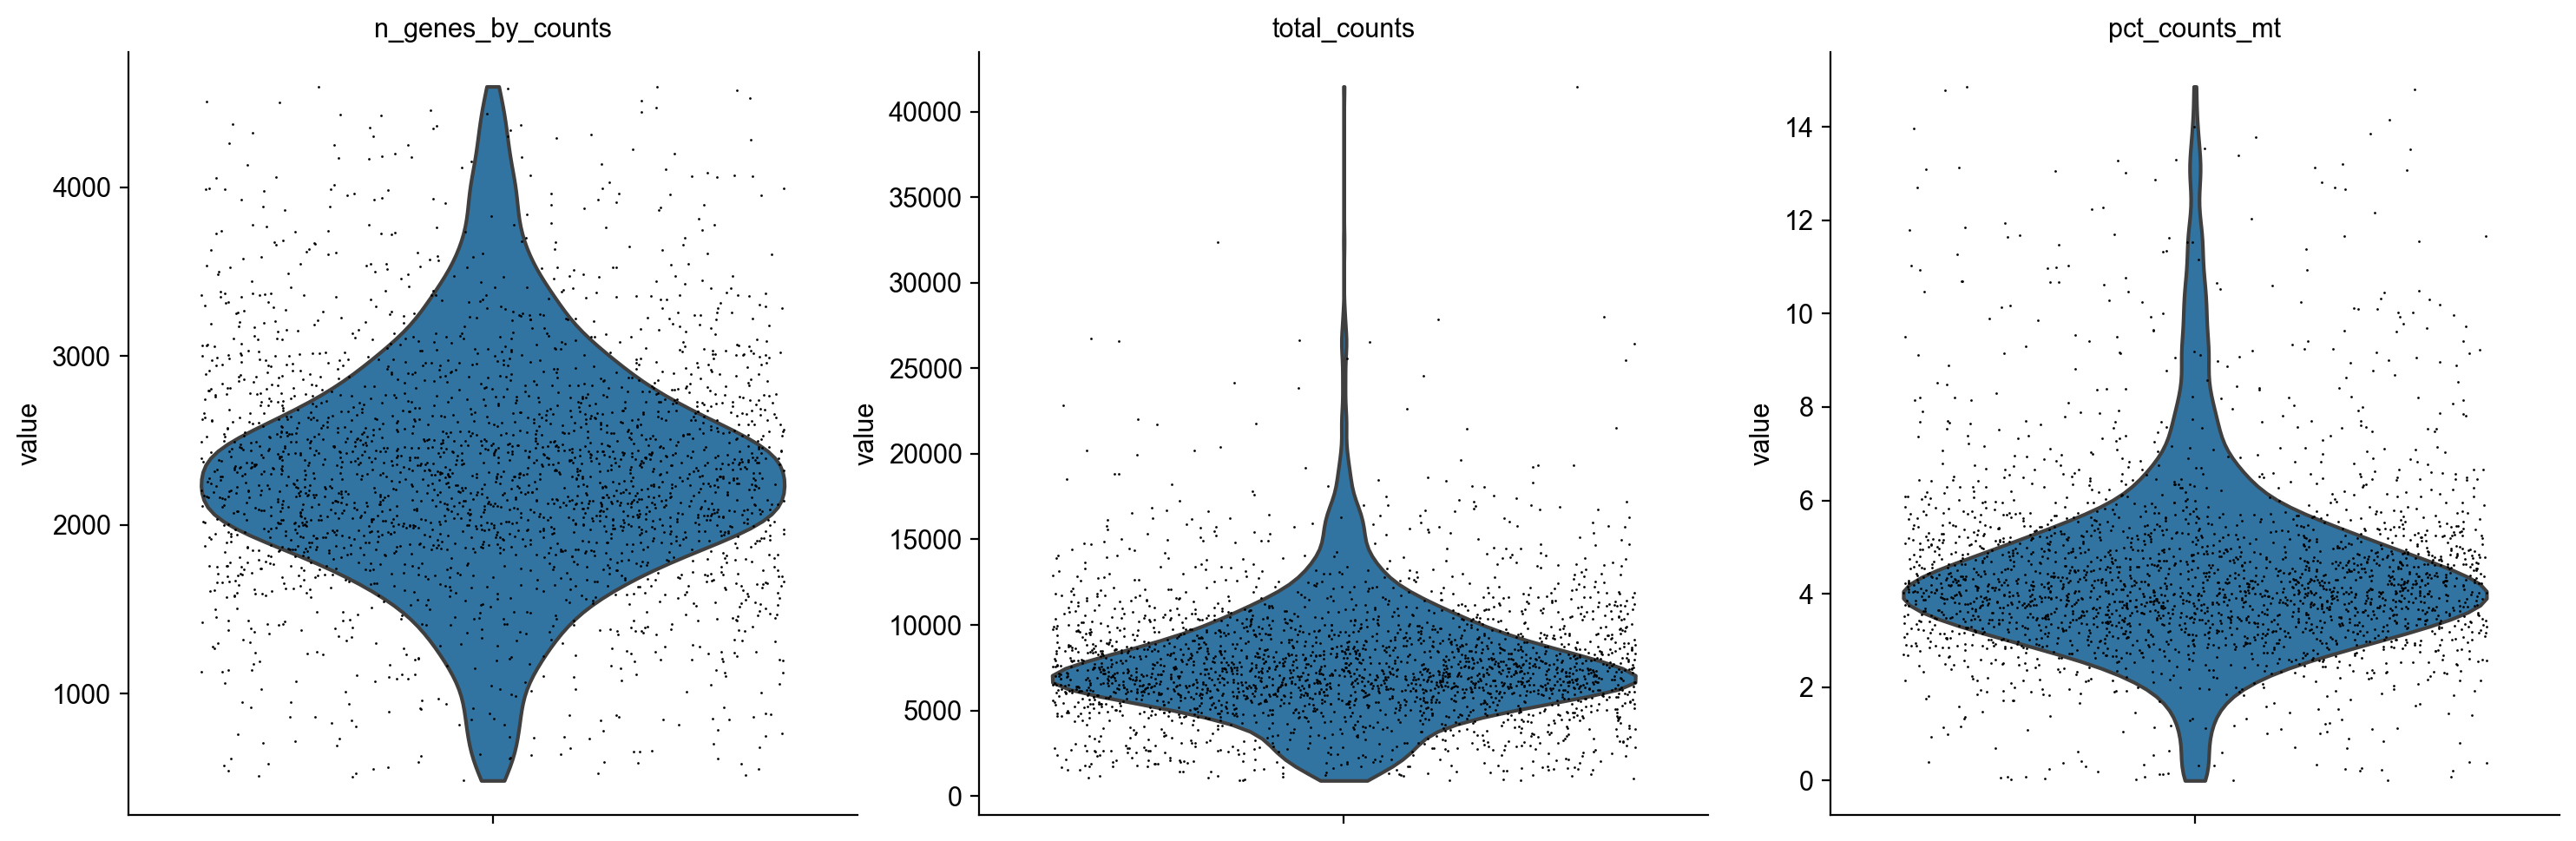

In [13]:
adata1 = adata1[(adata1.obs.n_genes_by_counts < upper_lim) & (adata1.obs.n_genes_by_counts > lower_lim)]
adata1 = adata1[adata1.obs.pct_counts_mt < 15]

sc.pl.violin(adata1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [14]:
adata1

View of AnnData object with n_obs × n_vars = 2586 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

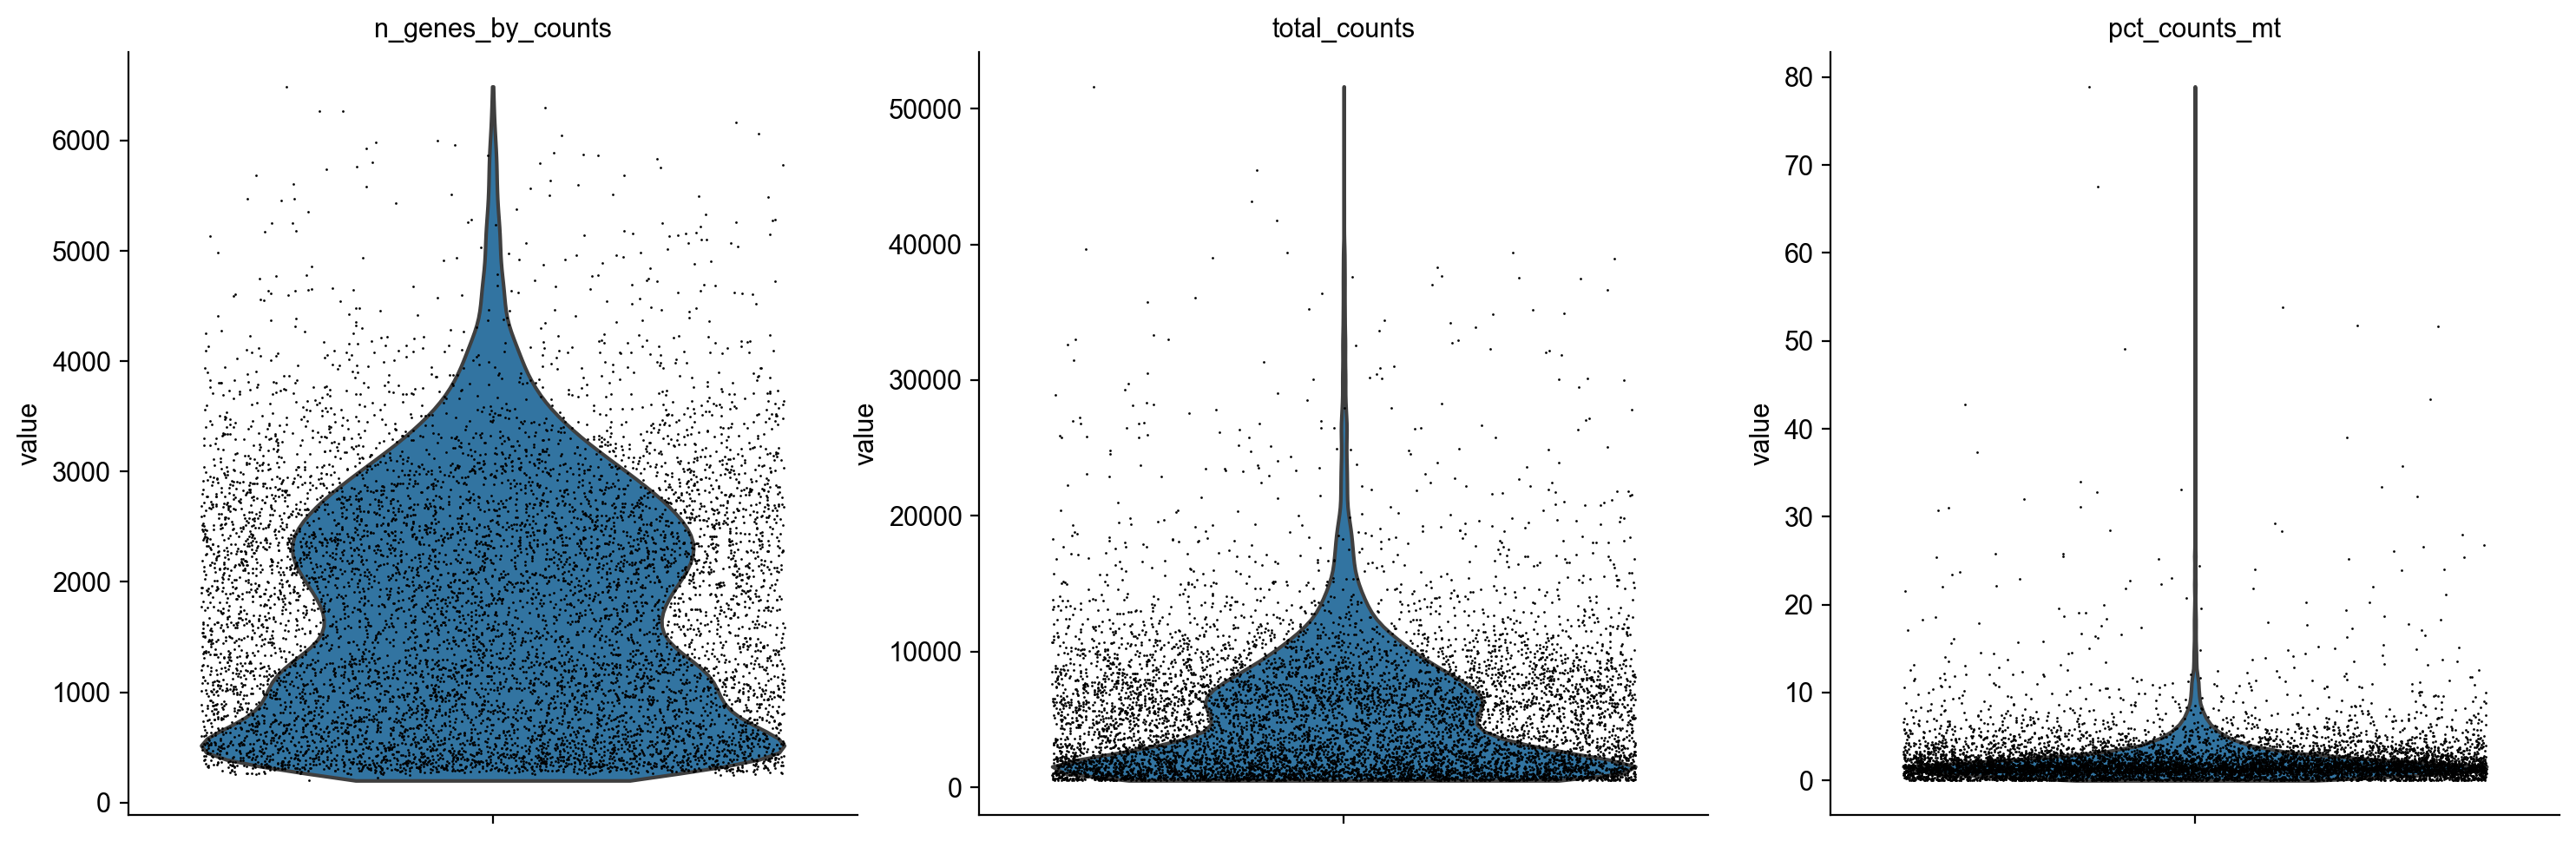

In [15]:
adata2.var['mt']= adata2.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [16]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata2.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata2.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

306.0 to 4236.919999999998


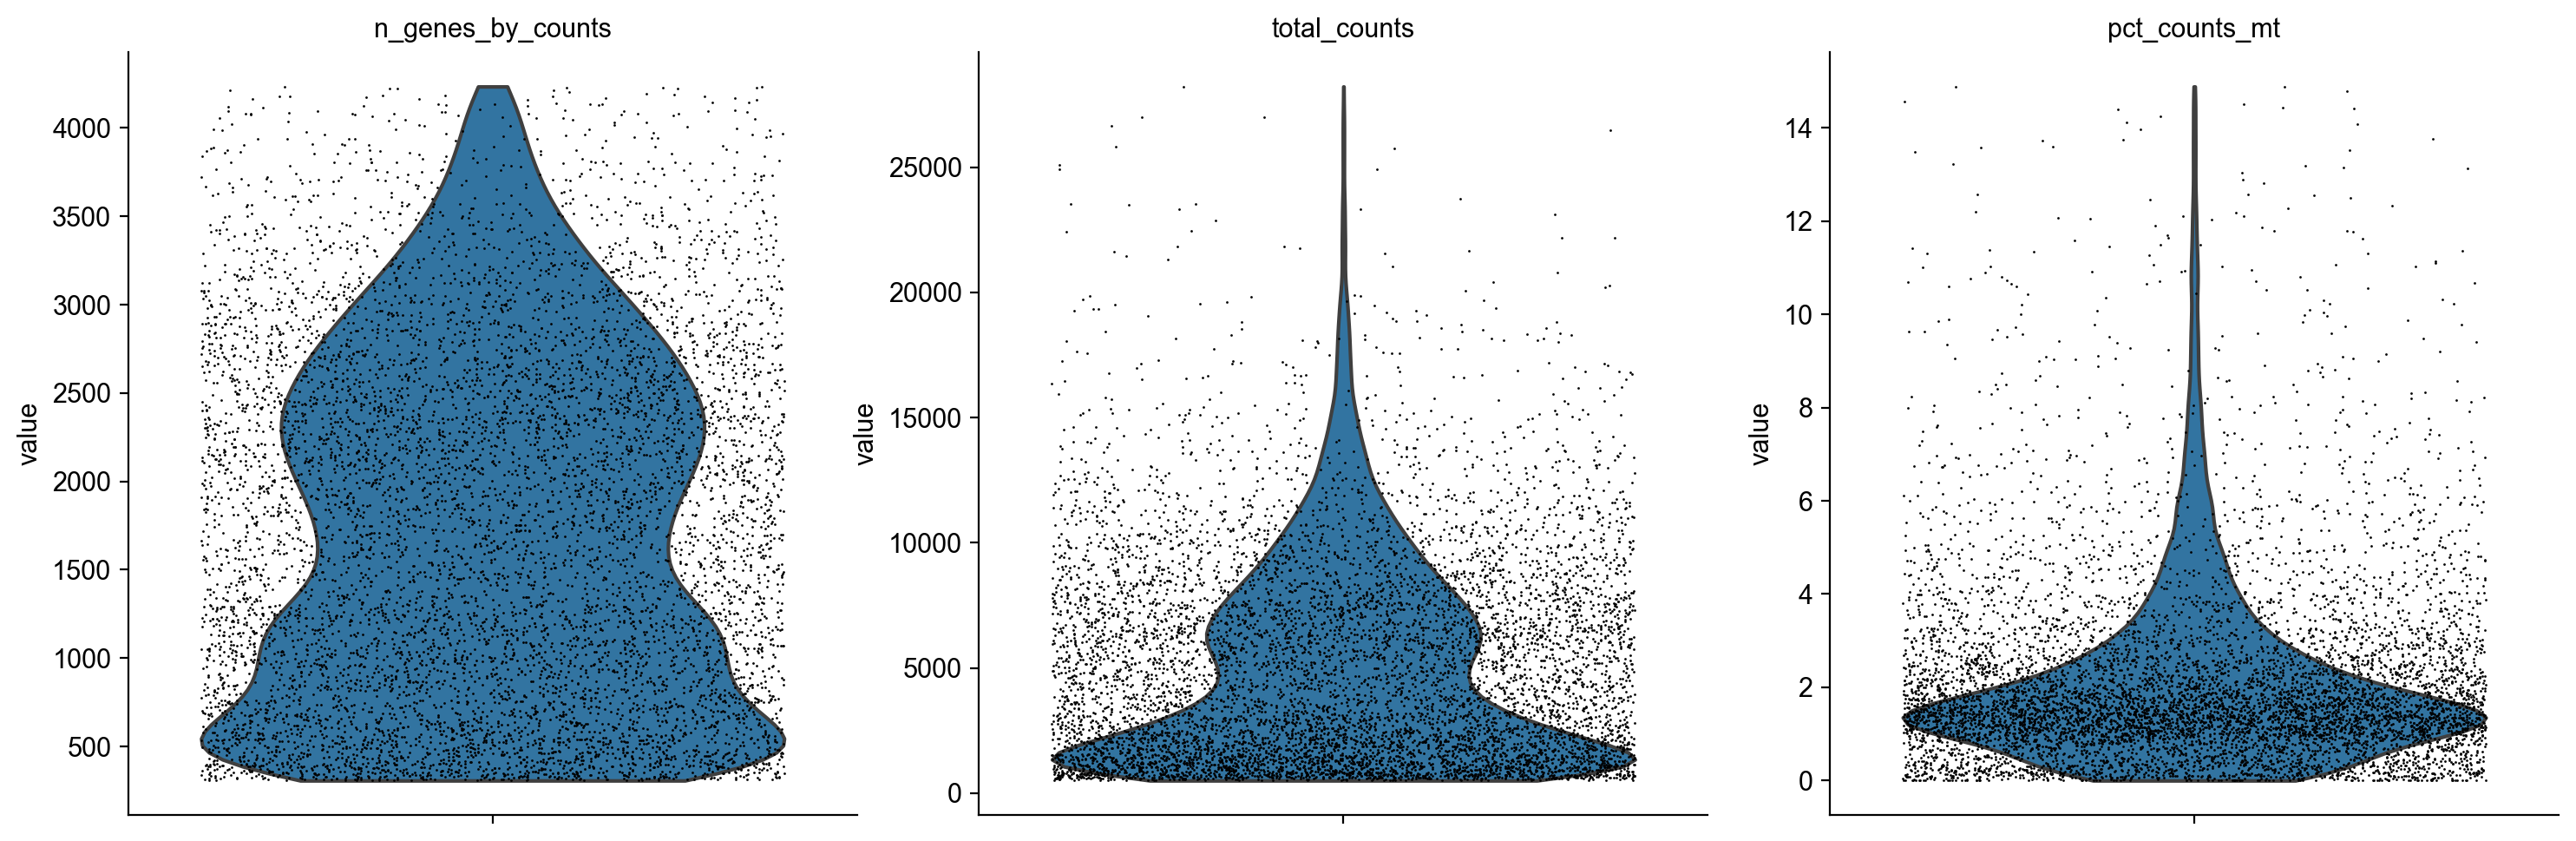

In [17]:
adata2 = adata2[(adata2.obs.n_genes_by_counts < upper_lim) & (adata2.obs.n_genes_by_counts > lower_lim)]
adata2 = adata2[adata2.obs.pct_counts_mt < 15]

sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [18]:
adata2

View of AnnData object with n_obs × n_vars = 8018 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

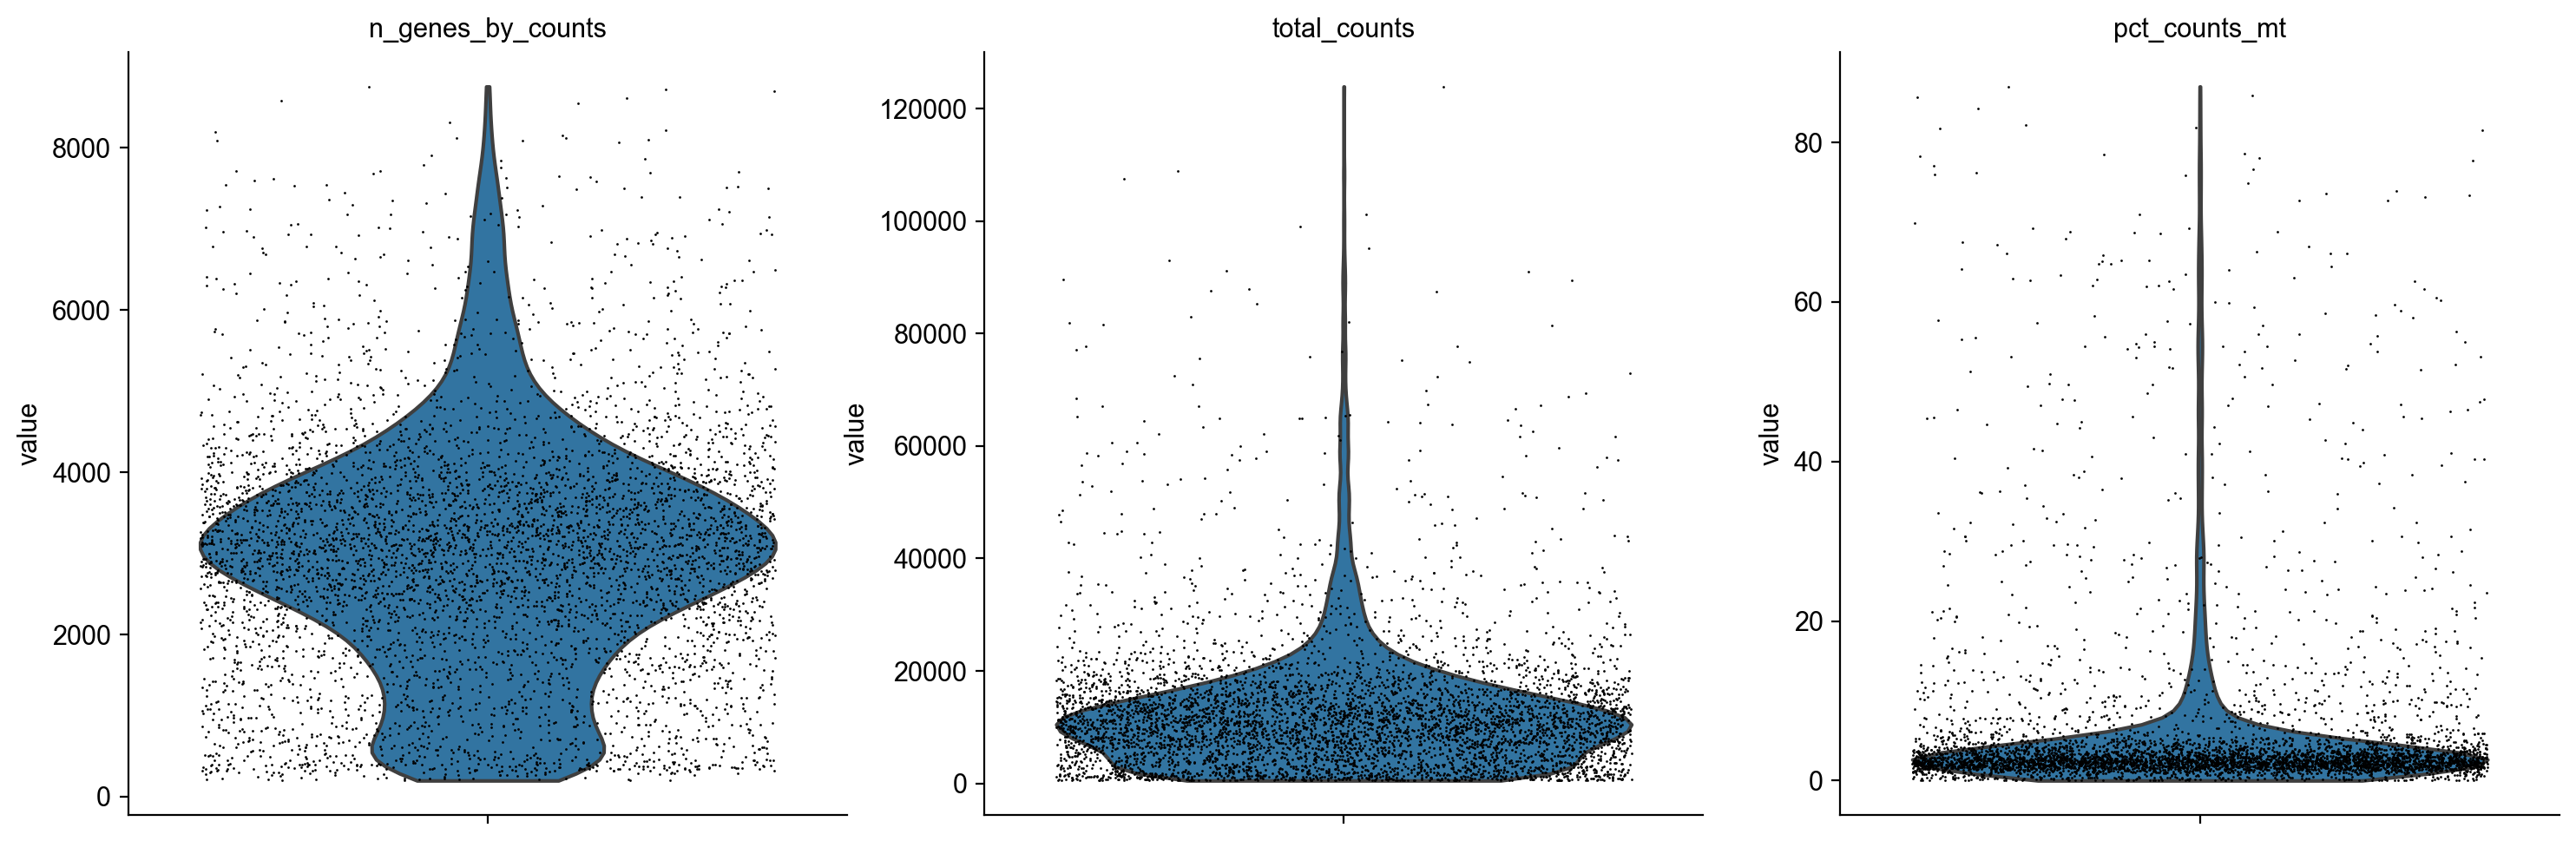

In [19]:
adata3.var['mt']= adata3.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes
sc.pp.calculate_qc_metrics(adata3, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata3, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [20]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata3.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata3.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

344.0 to 6715.0000000000055


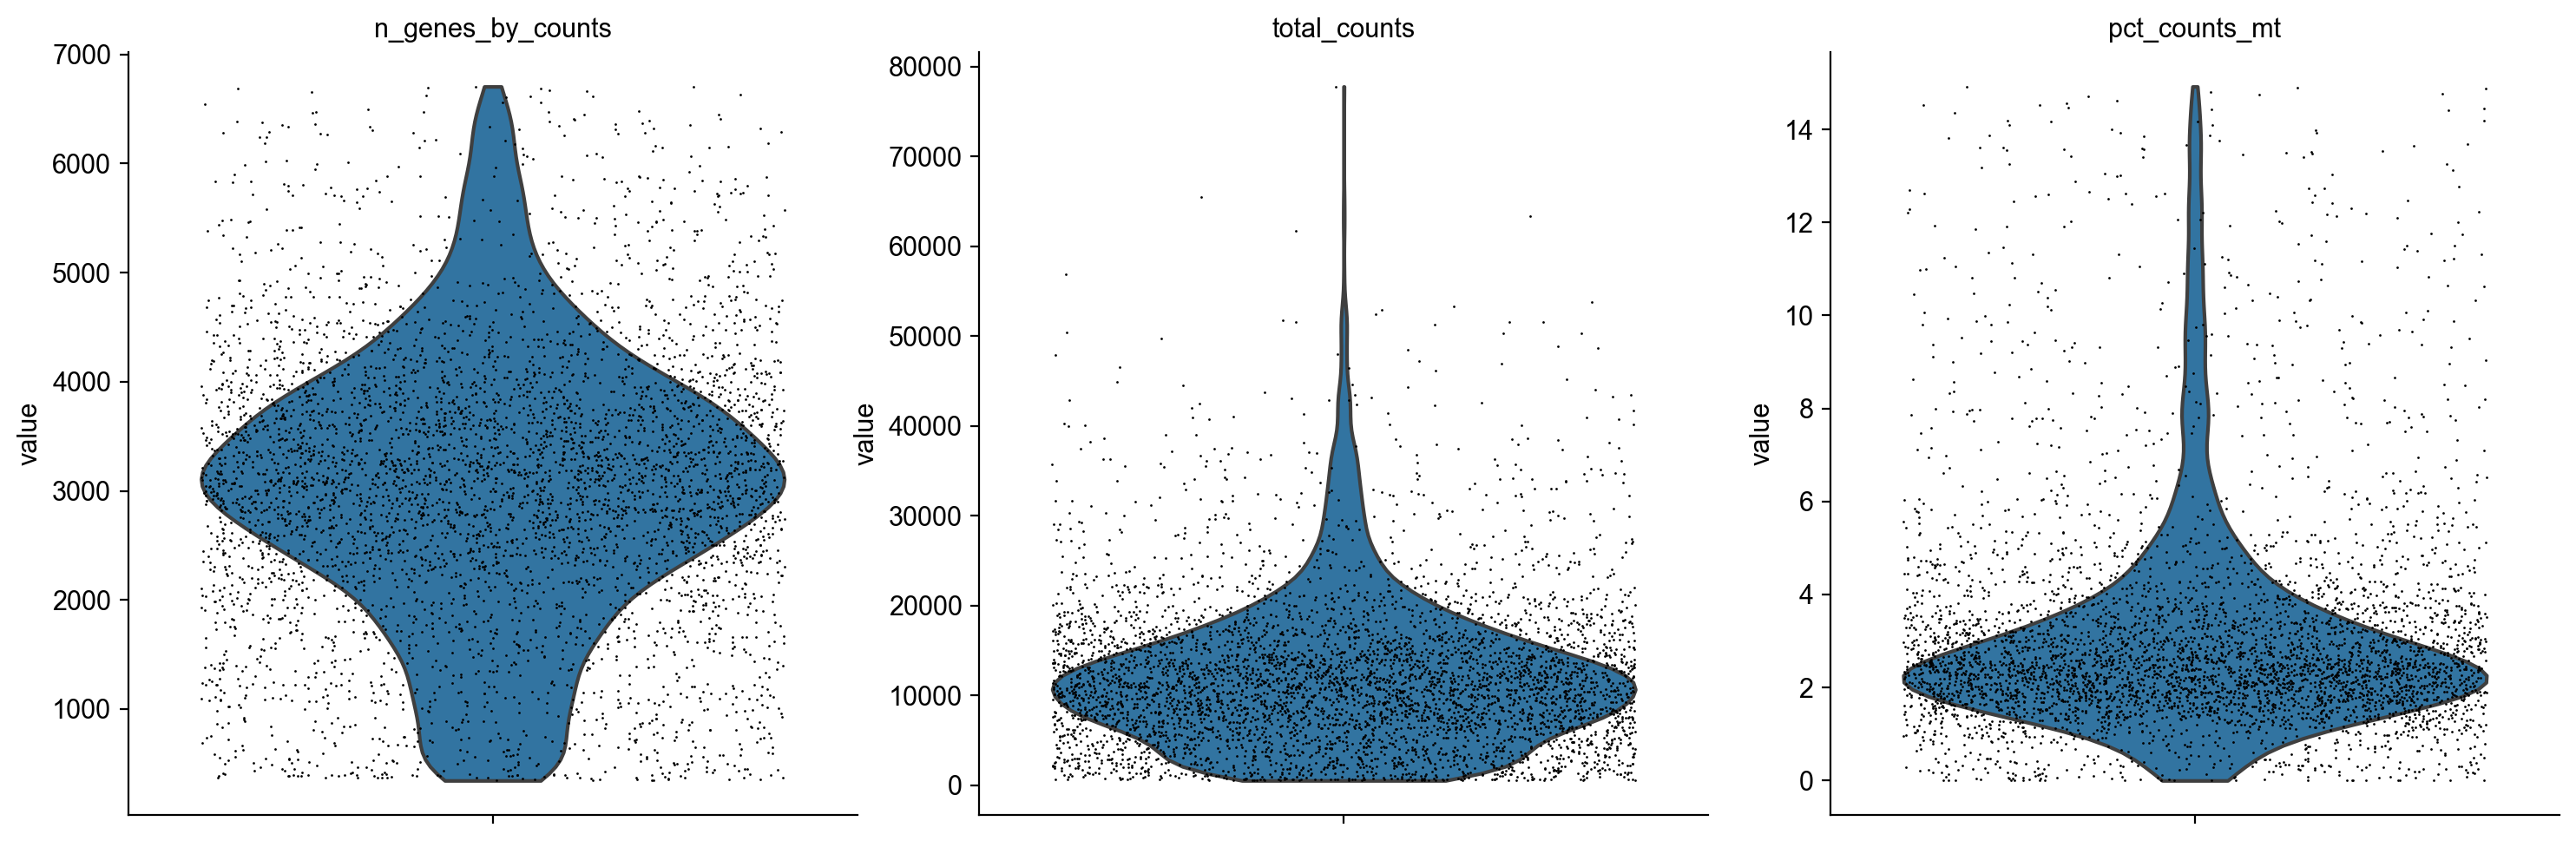

In [21]:
adata3 = adata3[(adata3.obs.n_genes_by_counts < upper_lim) & (adata3.obs.n_genes_by_counts > lower_lim)]
adata3 = adata3[adata3.obs.pct_counts_mt < 15]

sc.pl.violin(adata3, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [22]:
adata3

View of AnnData object with n_obs × n_vars = 4702 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

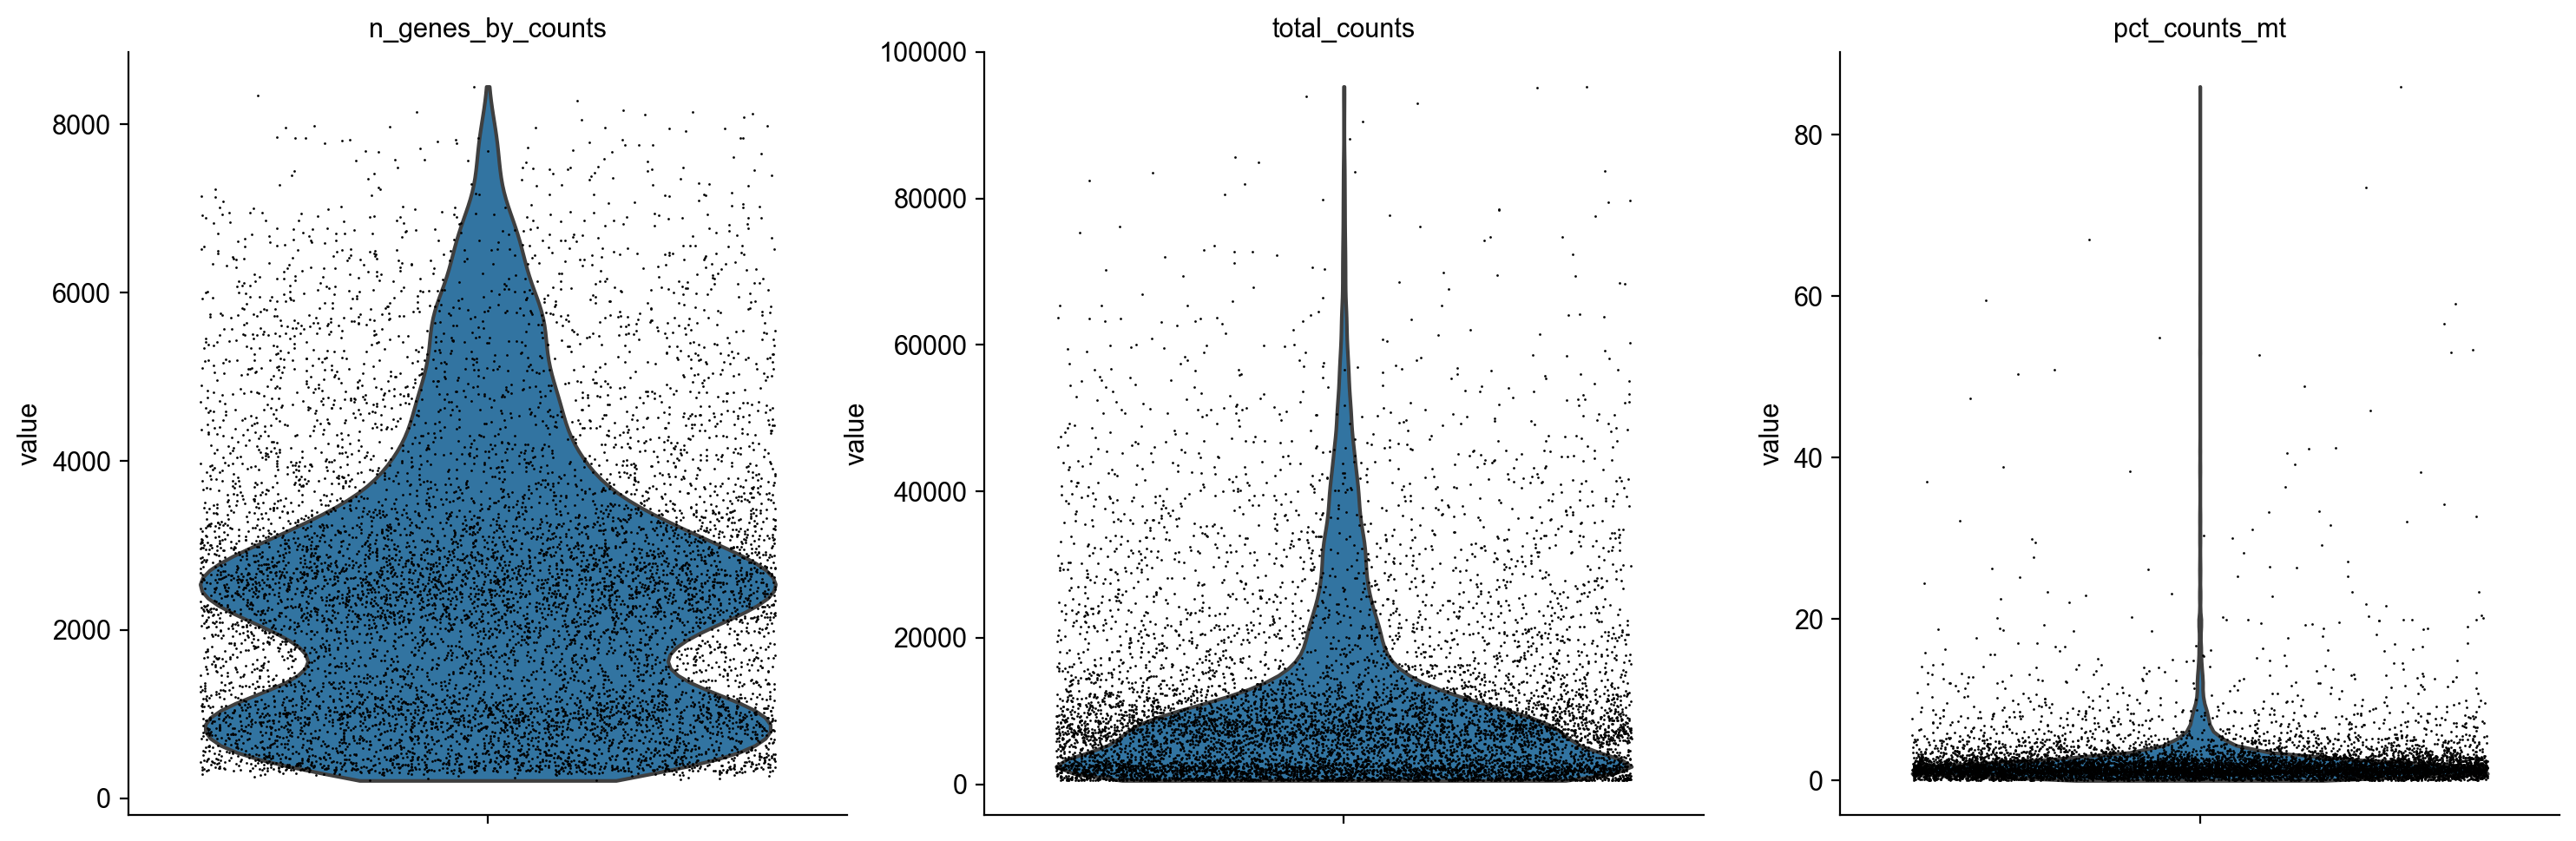

In [23]:
adata4.var['mt']= adata4.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes
sc.pp.calculate_qc_metrics(adata4, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [24]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata4.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata4.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

344.0 to 6712.700000000001


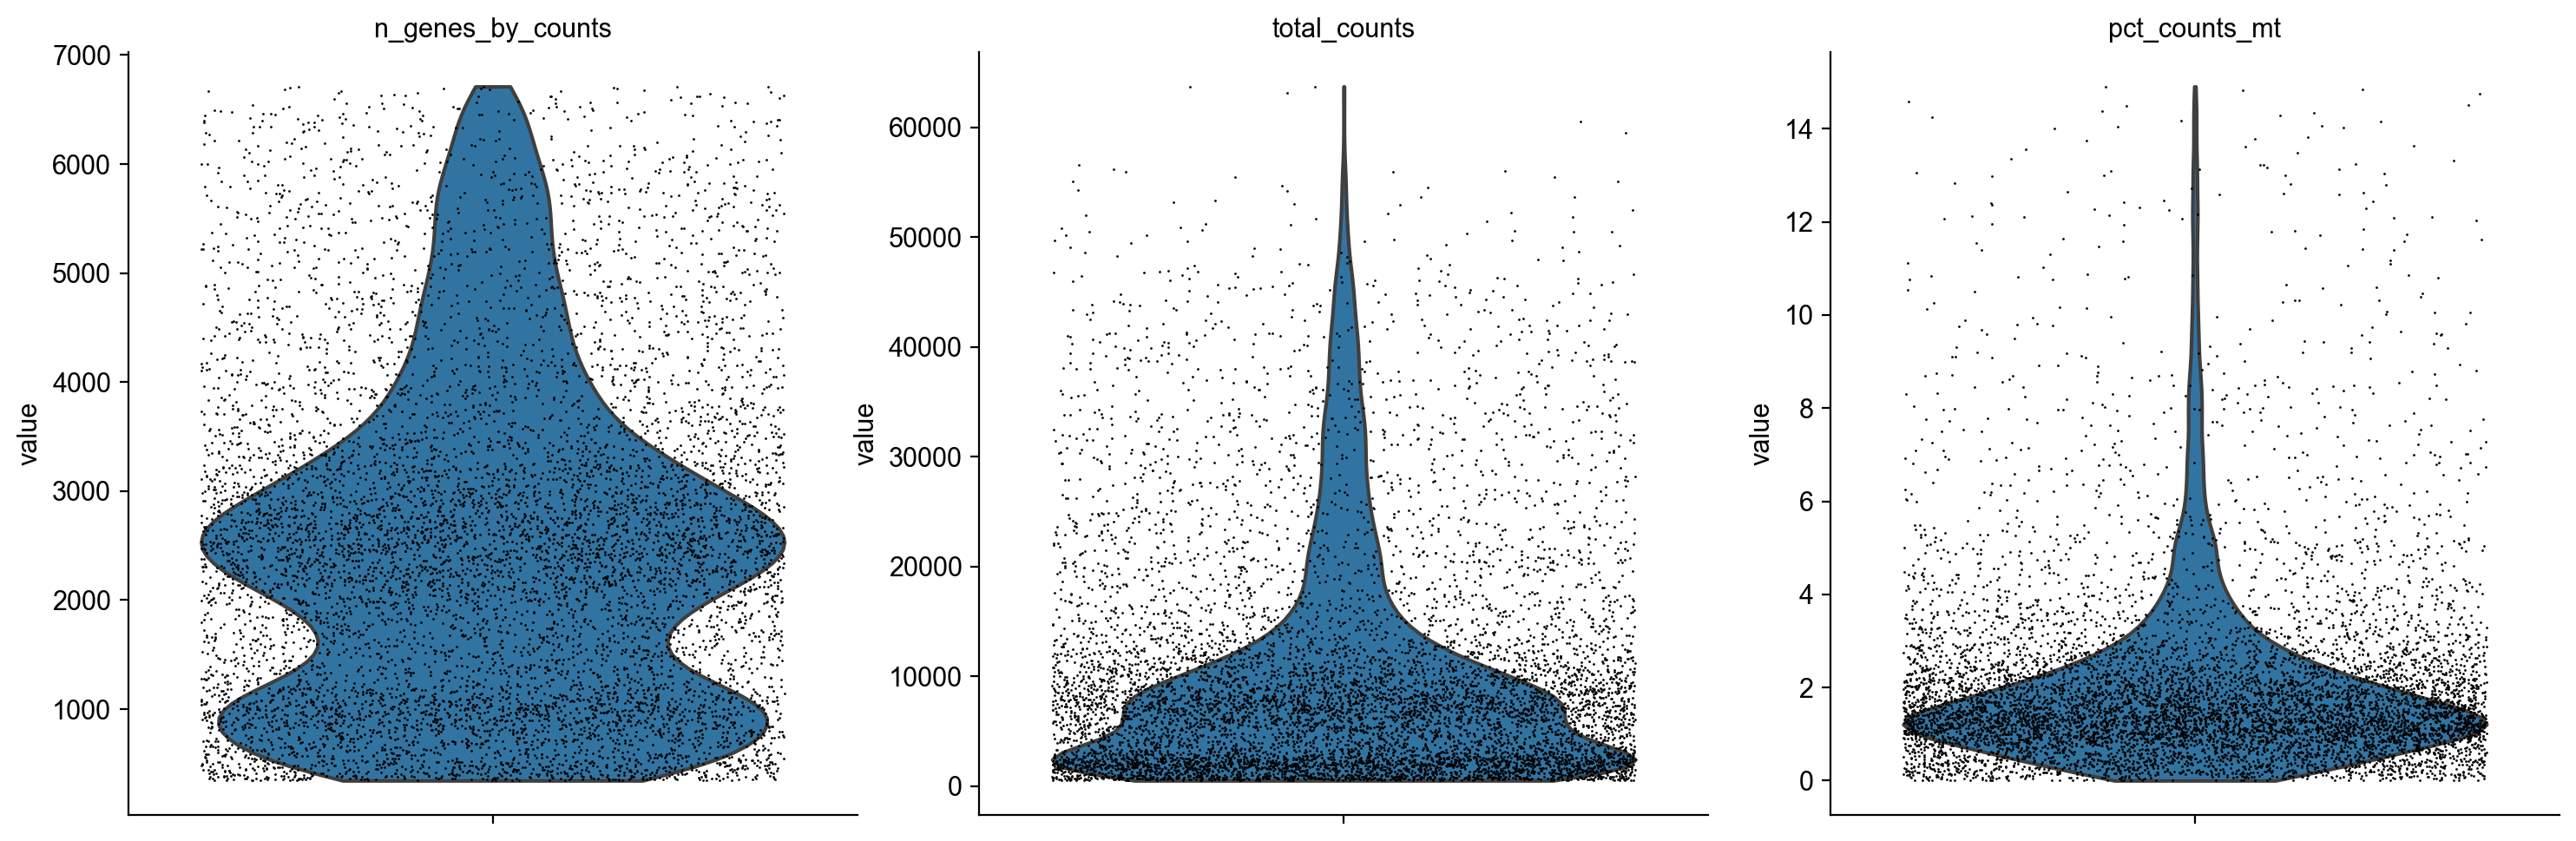

In [25]:
adata4 = adata4[(adata4.obs.n_genes_by_counts < upper_lim) & (adata4.obs.n_genes_by_counts > lower_lim)]
adata4 = adata4[adata4.obs.pct_counts_mt < 15]

sc.pl.violin(adata4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [26]:
adata4

View of AnnData object with n_obs × n_vars = 8506 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

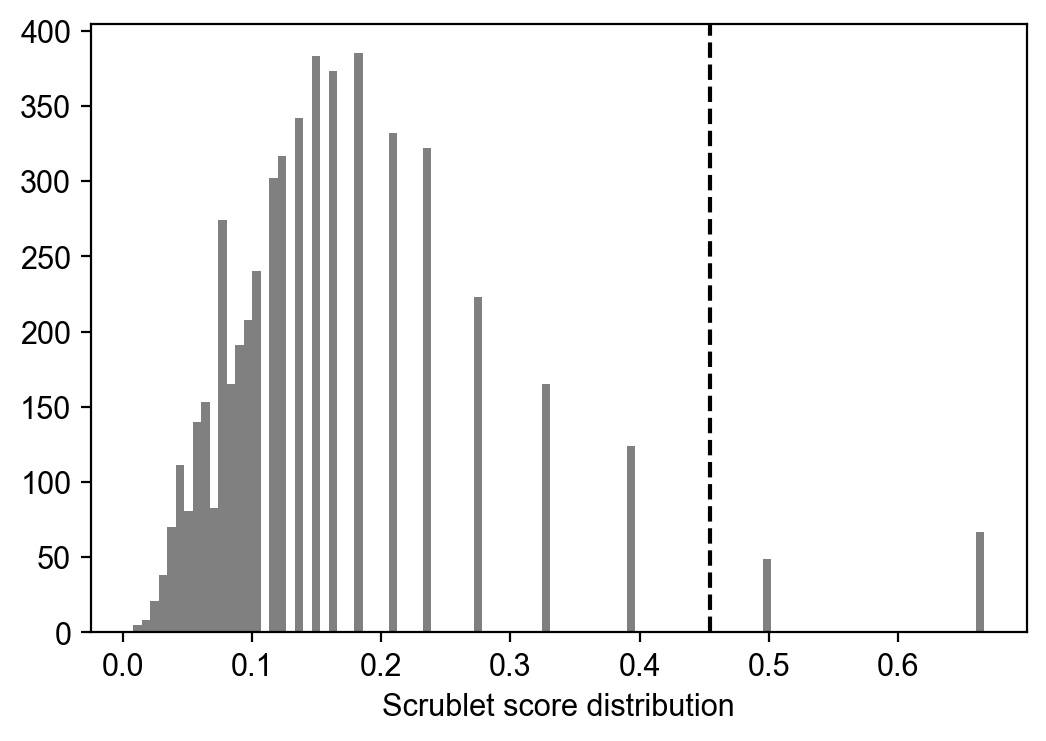

In [27]:
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt

# Compute scrublet scores
sc.external.pp.scrublet(adata1, verbose=False)  # Corrected function call

# Compute scrublet scores
sc.external.pp.scrublet(adata1, verbose=False)  # Corrected function call

# Define plotting function
def plot_scrublet_scores(adata, ax):
    thr = adata.uns['scrublet']['threshold']
    # Plot histogram
    doublet_scores = adata.uns['scrublet']['doublet_scores_sim']  
    ax.hist(doublet_scores, bins=100, color='gray')
    ax.axvline(x=thr, linestyle='--', color="black")
    ax.set_xlabel('Scrublet score distribution')

# Plot
fig, ax = plt.subplots(1, 1)
plot_scrublet_scores(adata1, ax)  

In [28]:
print(adata1.obs)

                    n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTTCCGTTC-1     4116               4116       15405.0            653.0   
AAACCCATCCATACTT-1     2850               2850       10036.0            417.0   
AAACCCATCCCACAGG-1     2414               2414        7717.0            212.0   
AAACGAACATACCACA-1     2668               2668        9444.0            274.0   
AAACGAAGTCGTGGTC-1     2716               2716        9703.0            588.0   
...                     ...                ...           ...              ...   
TTTGGTTGTGACTGTT-1     1572               1572        4890.0            194.0   
TTTGGTTGTTTGACAC-1     3674               3674       15389.0            534.0   
TTTGTTGCACTCTAGA-1     2304               2304        7794.0            285.0   
TTTGTTGTCATTGTTC-1     2293               2293        6699.0            266.0   
TTTGTTGTCCACTGGG-1     2302               2302        6982.0            259.0   

                    pct_cou

In [29]:
num_predicted_doublets = sum(adata1.obs['predicted_doublet'])
print("Number of cells predicted as doublets before filtering:", num_predicted_doublets)


Number of cells predicted as doublets before filtering: 4


In [30]:
threshold = 0.3  # Set your desired threshold here
adata1 = adata1[adata1.obs['doublet_score'] < threshold]

In [31]:
adata1

View of AnnData object with n_obs × n_vars = 2563 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

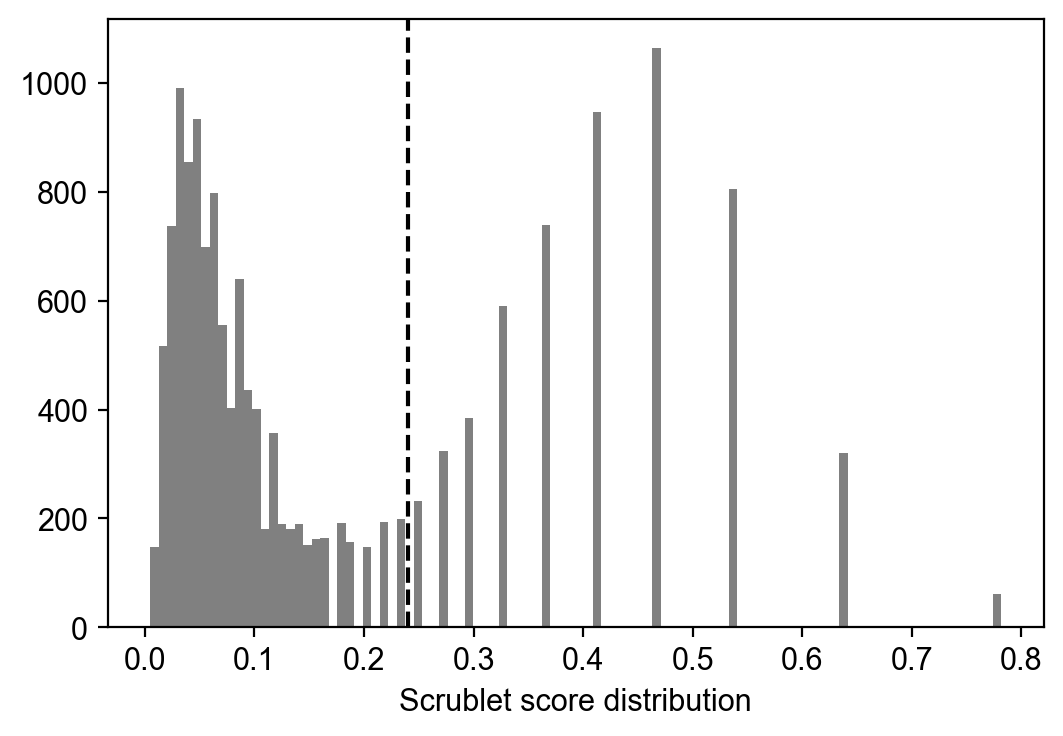

In [32]:

# Compute scrublet scores
sc.external.pp.scrublet(adata2, verbose=False)  # Corrected function call

# Compute scrublet scores
sc.external.pp.scrublet(adata2, verbose=False)  # Corrected function call

# Define plotting function
def plot_scrublet_scores(adata, ax):
    thr = adata.uns['scrublet']['threshold']
    # Plot histogram
    doublet_scores = adata.uns['scrublet']['doublet_scores_sim']  
    ax.hist(doublet_scores, bins=100, color='gray')
    ax.axvline(x=thr, linestyle='--', color="black")
    ax.set_xlabel('Scrublet score distribution')

# Plot
fig, ax = plt.subplots(1, 1)
plot_scrublet_scores(adata2, ax)  

In [33]:
num_predicted_doublets = sum(adata2.obs['predicted_doublet'])
print("Number of cells predicted as doublets before filtering:", num_predicted_doublets)


Number of cells predicted as doublets before filtering: 152


In [34]:
print(adata2.obs)

                    n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCTTCATG-1     2293               2293        7138.0            146.0   
AAACCCAGTAAGATCA-1     4133               4133       14660.0            326.0   
AAACCCAGTGGCTGCT-1     2327               2327        6701.0             89.0   
AAACCCAGTTGGTAGG-1     1656               1656        3377.0            111.0   
AAACCCATCCTTTGAT-1     1476               1476        2350.0             95.0   
...                     ...                ...           ...              ...   
TTTGTTGGTTCAAAGA-1     1043               1043        3272.0              2.0   
TTTGTTGGTTGTCATG-1     2169               2169        5669.0             53.0   
TTTGTTGTCAGAGTTC-1      400                400         801.0             14.0   
TTTGTTGTCCGCACGA-1     3244               3244       10304.0            197.0   
TTTGTTGTCGACACTA-1     2775               2775        8797.0             96.0   

                    pct_cou

In [35]:
threshold = 0.25  # Set your desired threshold here
adata2 = adata2[adata2.obs['doublet_score'] < threshold]

In [36]:
adata2

View of AnnData object with n_obs × n_vars = 7866 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

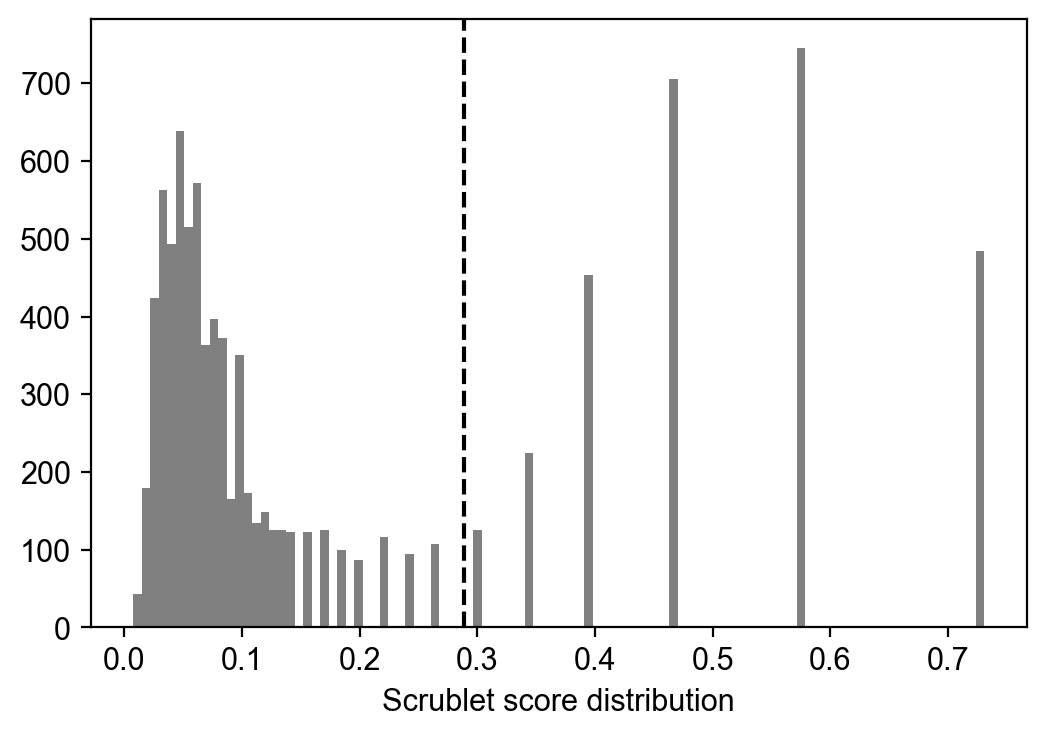

In [37]:

# Compute scrublet scores
sc.external.pp.scrublet(adata3, verbose=False)  # Corrected function call

# Compute scrublet scores
sc.external.pp.scrublet(adata3, verbose=False)  # Corrected function call

# Define plotting function
def plot_scrublet_scores(adata, ax):
    thr = adata.uns['scrublet']['threshold']
    # Plot histogram
    doublet_scores = adata.uns['scrublet']['doublet_scores_sim']  
    ax.hist(doublet_scores, bins=100, color='gray')
    ax.axvline(x=thr, linestyle='--', color="black")
    ax.set_xlabel('Scrublet score distribution')

# Plot
fig, ax = plt.subplots(1, 1)
plot_scrublet_scores(adata3, ax)  

In [38]:
num_predicted_doublets = sum(adata3.obs['predicted_doublet'])
print("Number of cells predicted as doublets before filtering:", num_predicted_doublets)


Number of cells predicted as doublets before filtering: 49


In [39]:
print(adata3.obs)

                    n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGTACAGAT-1     2219               2219        6572.0            370.0   
AAACCCAAGTGGAATT-1     4286               4286       19216.0            577.0   
AAACCCACAAGAGGCT-1     3671               3671       18057.0            439.0   
AAACCCACAGGTACGA-1     1869               1869        5703.0            205.0   
AAACCCAGTTCGGCCA-1     5402               5402       32446.0            476.0   
...                     ...                ...           ...              ...   
TTTGGTTTCCCGGTAG-1     1709               1709        4944.0            216.0   
TTTGTTGAGATACAGT-1     3195               3195       12007.0            359.0   
TTTGTTGAGTCGAGGT-1     3613               3613       13895.0            345.0   
TTTGTTGTCAAACGTC-1     2639               2639        7356.0            232.0   
TTTGTTGTCCCGAAAT-1      738                738        1258.0             73.0   

                    pct_cou

In [40]:
threshold = 0.29  # Set your desired threshold here
adata3 = adata3[adata3.obs['doublet_score'] < threshold]

In [41]:
adata3

View of AnnData object with n_obs × n_vars = 4653 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

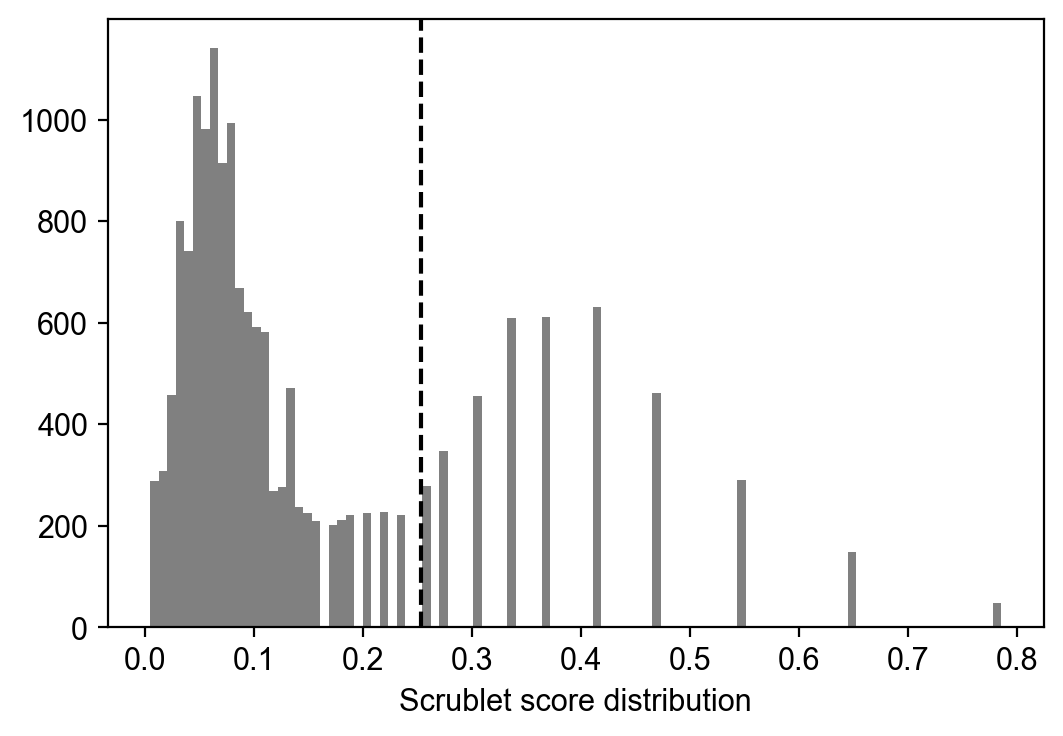

In [42]:

# Compute scrublet scores
sc.external.pp.scrublet(adata4, verbose=False)  # Corrected function call

# Compute scrublet scores
sc.external.pp.scrublet(adata4, verbose=False)  # Corrected function call

# Define plotting function
def plot_scrublet_scores(adata, ax):
    thr = adata.uns['scrublet']['threshold']
    # Plot histogram
    doublet_scores = adata.uns['scrublet']['doublet_scores_sim']  
    ax.hist(doublet_scores, bins=100, color='gray')
    ax.axvline(x=thr, linestyle='--', color="black")
    ax.set_xlabel('Scrublet score distribution')

# Plot
fig, ax = plt.subplots(1, 1)
plot_scrublet_scores(adata4, ax)  

In [43]:
num_predicted_doublets = sum(adata4.obs['predicted_doublet'])
print("Number of cells predicted as doublets before filtering:", num_predicted_doublets)


Number of cells predicted as doublets before filtering: 137


In [44]:
print(adata4.obs)

                    n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGGATGCGT-1      899                899        1327.0             68.0   
AAACCCACACCGCTAG-1      527                527        1041.0             21.0   
AAACCCACATGACGGA-1     3794               3794       15435.0            242.0   
AAACCCATCATCACCC-1      862                862        1807.0              5.0   
AAACCCATCATGCGGC-1     4028               4028       23439.0            499.0   
...                     ...                ...           ...              ...   
TTTGTTGAGATGGCGT-1     1873               1873        4125.0            218.0   
TTTGTTGCACCGAATT-1     4590               4590       23666.0            426.0   
TTTGTTGCATCCTTCG-1     3014               3014       10031.0            198.0   
TTTGTTGGTCAGGAGT-1     1780               1780        4392.0             67.0   
TTTGTTGGTTGTGCAT-1     2986               2986        8995.0            427.0   

                    pct_cou

In [45]:
threshold = 0.25  # Set your desired threshold here
adata4 = adata4[adata4.obs['doublet_score'] < threshold]

In [46]:
adata4

View of AnnData object with n_obs × n_vars = 8369 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [47]:
# Create a copy of the original AnnData object
#raw_adata = adata.copy()


In [47]:
adata = adata1.concatenate([adata2,adata3,adata4], batch_categories=['Sham_GFP', 'Sham_noGFP', 'OV_GFP', 'OV_noGFP'])

In [48]:
adata

AnnData object with n_obs × n_vars = 23451 × 32285
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-OV_GFP', 'mean_counts-OV_GFP', 'pct_dropout_by_counts-OV_GFP', 'total_counts-OV_GFP', 'n_cells_by_counts-OV_noGFP', 'mean_counts-OV_noGFP', 'pct_dropout_by_counts-OV_noGFP', 'total_counts-OV_noGFP', 'n_cells_by_counts-Sham_GFP', 'mean_counts-Sham_GFP', 'pct_dropout_by_counts-Sham_GFP', 'total_counts-Sham_GFP', 'n_cells_by_counts-Sham_noGFP', 'mean_counts-Sham_noGFP', 'pct_dropout_by_counts-Sham_noGFP', 'total_counts-Sham_noGFP'

In [49]:
# filter
sc.pp.filter_genes(adata, min_cells=10)

In [50]:
adata.layers['counts'] = adata.X.copy()

In [51]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [52]:
#adata.layers['counts'] = adata.X.copy()

In [53]:
# Assuming adata is your AnnData object

# Access raw count data
raw_count_data = adata.X

# Print the shape of the raw count data
print("Shape of raw count data:", raw_count_data.shape)


Shape of raw count data: (23451, 20540)


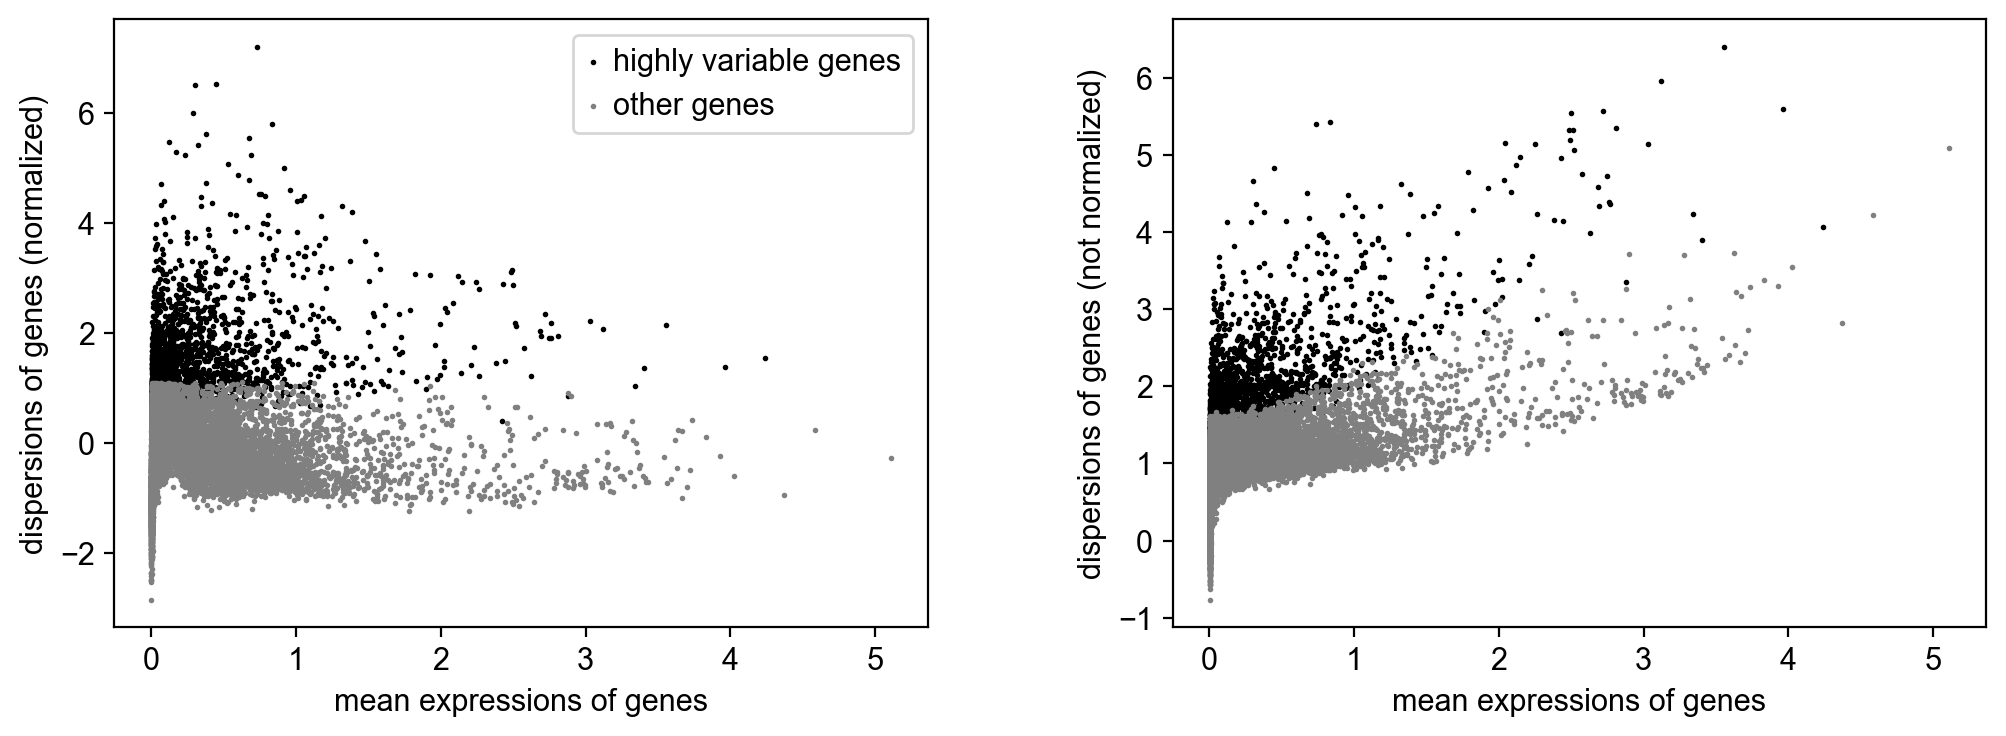

In [52]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_bins=20, batch_key='batch', n_top_genes=2000)

sc.pl.highly_variable_genes(adata)#, save=f"{projID}_high_variable_{n3}.png")

In [53]:
sc.pp.scale(adata, max_value=10) 

In [54]:
sc.tl.pca(adata, svd_solver='arpack')

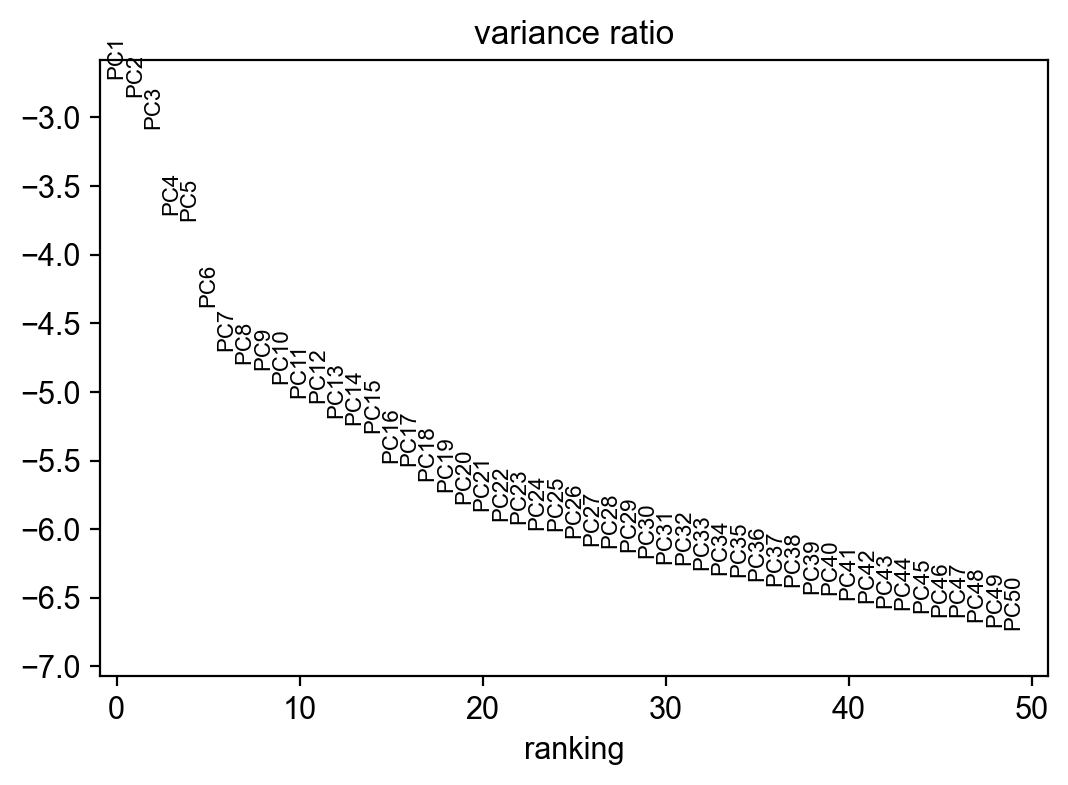

In [55]:
# Plot PCA variance ratio
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [56]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)

In [58]:
#BBKNN
bbknn.bbknn(adata, batch_key="batch")

In [59]:
sc.tl.umap(adata)

In [60]:
sc.tl.leiden(adata, resolution = 0.9)

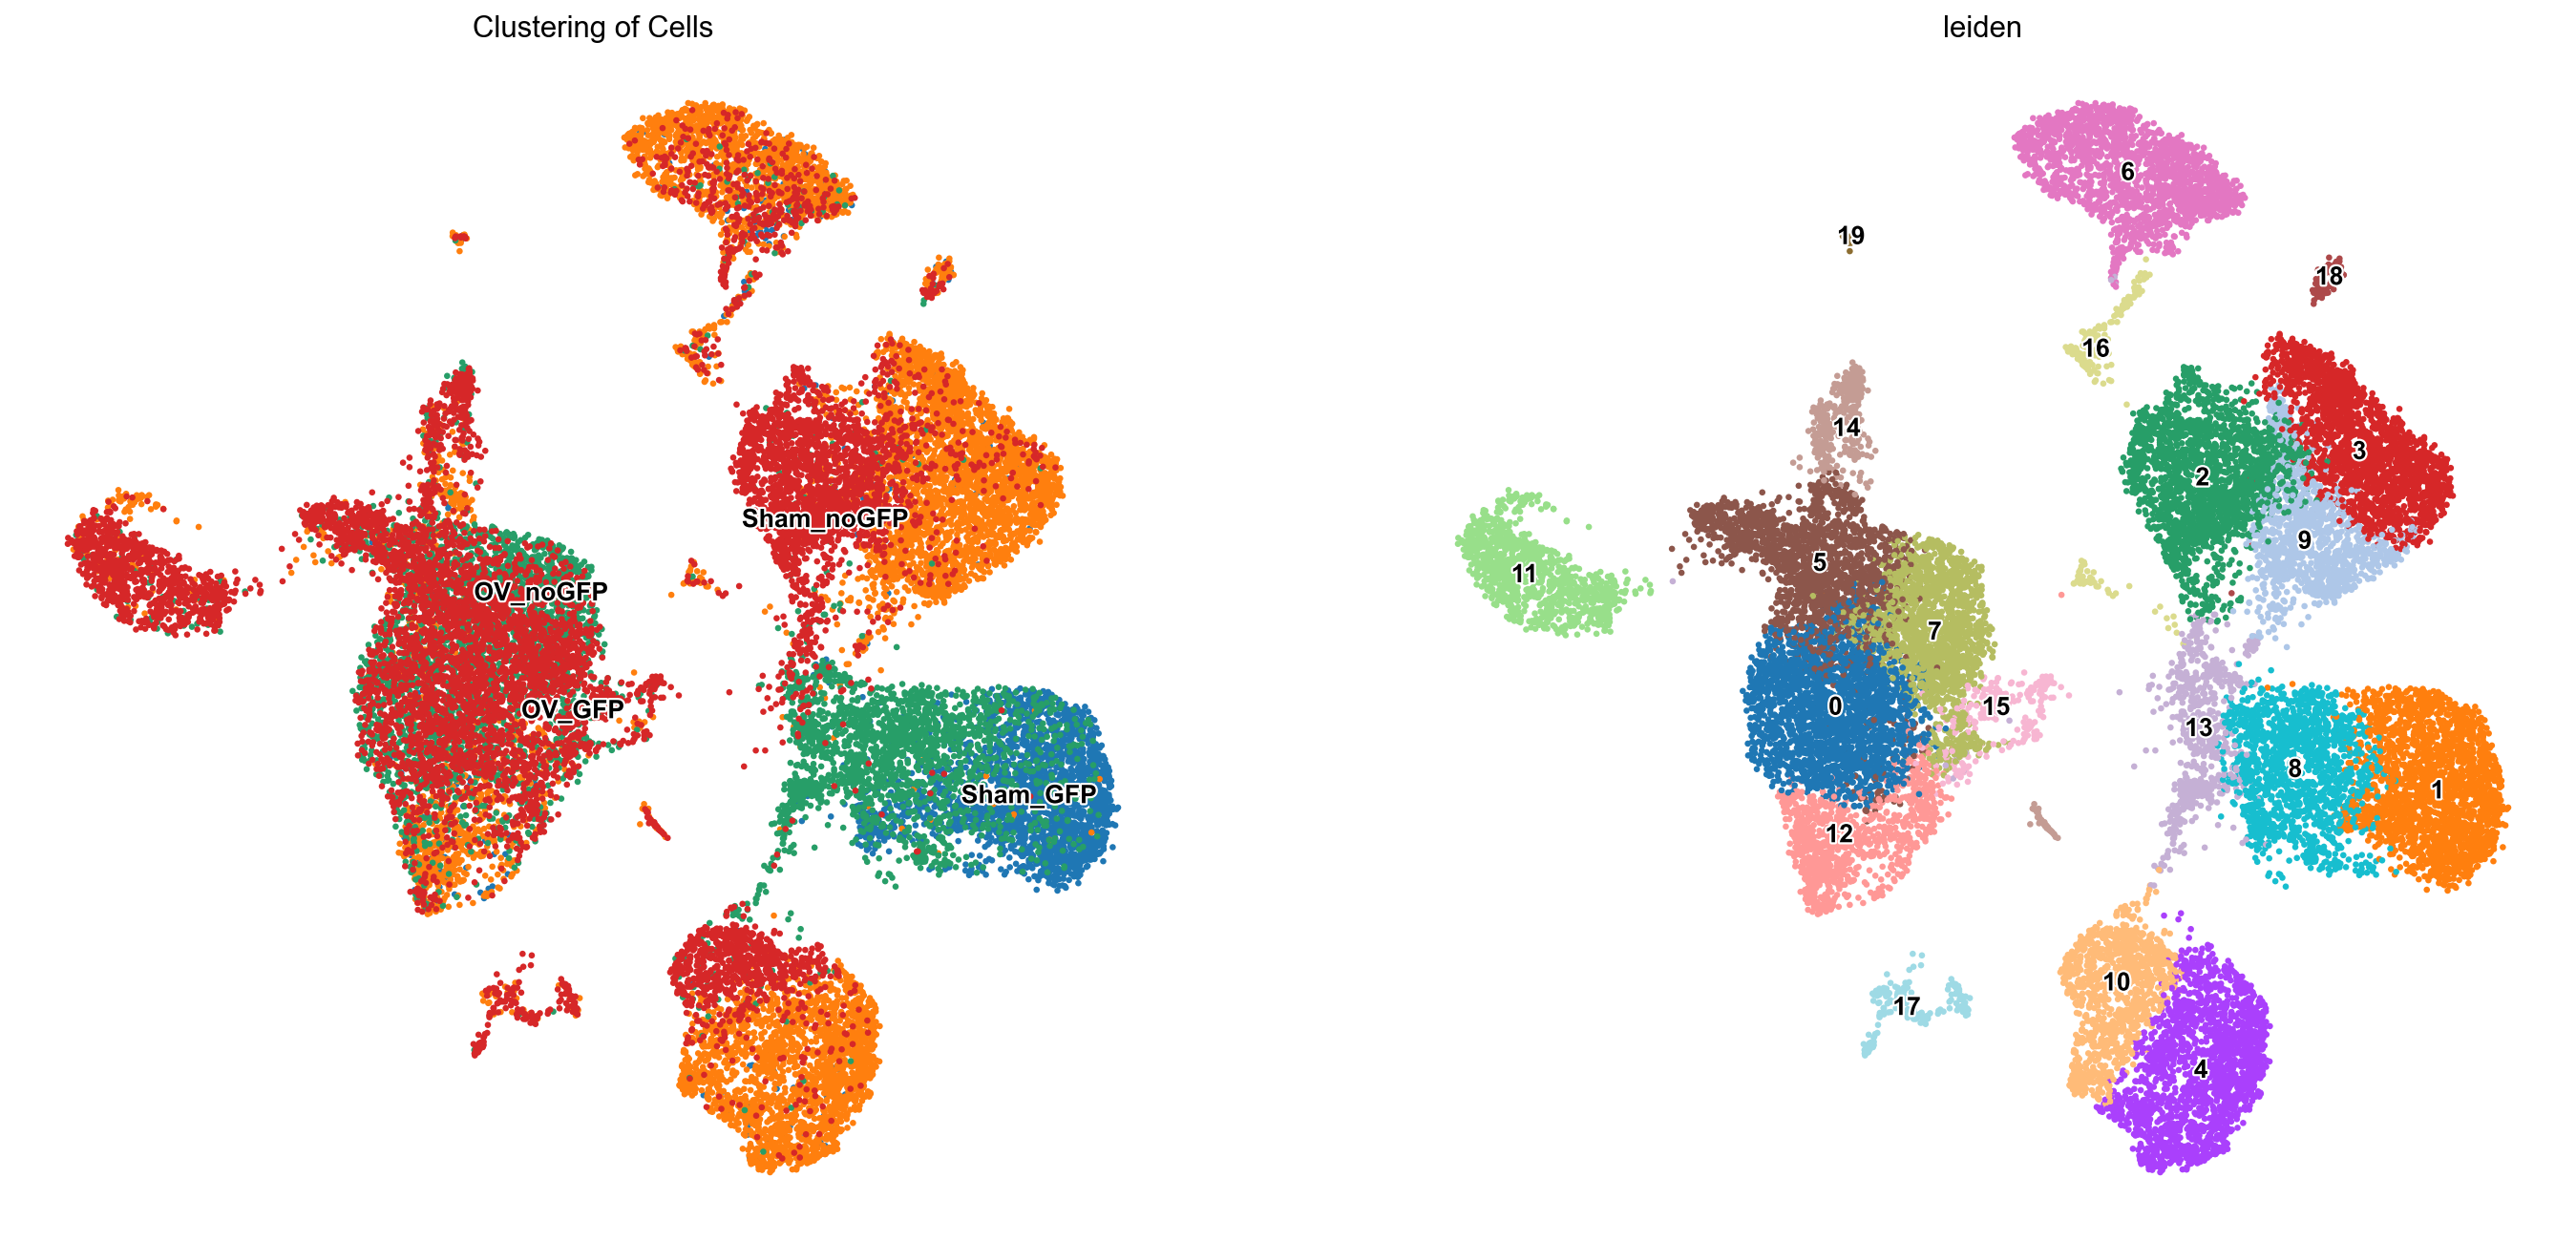

In [61]:

# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['batch', 'leiden'], legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells', save=f'umap_plot after integration sample and cell type{img_tag}.png')
pl.show()

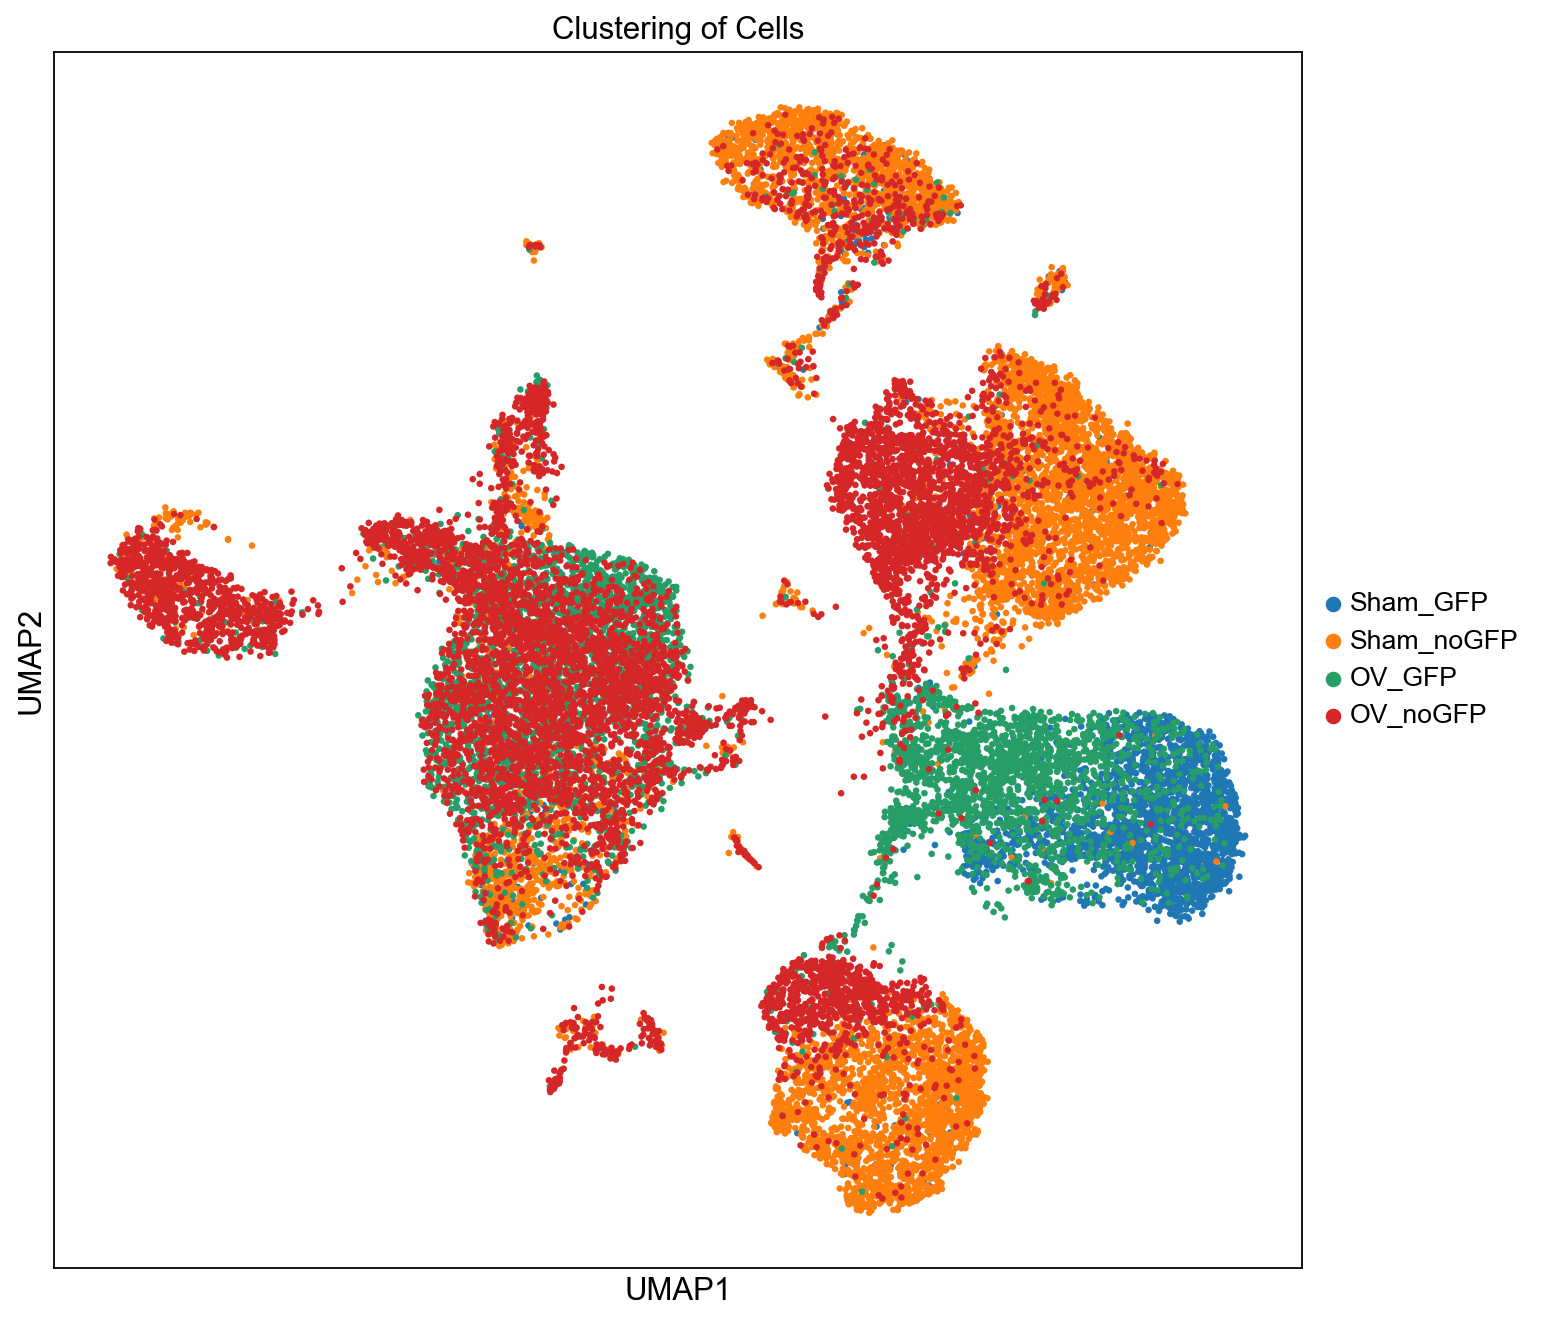

In [62]:

# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['batch'],  legend_fontsize=12, legend_fontoutline=2, frameon=True, size=35, title='Clustering of Cells', save=f'umap_plot after intesample{img_tag}.png')
pl.show()

In [71]:
def filter_anndata_by_gene(adata, gene, lim=1) -> "AnnData object":
    """filters anndata objects by gene
    
    Args: 
        adata: 'anndata object', that we are filtering
        gene: 'str', the gene we wish to filter by
    """
    ind = np.where(adata[:, [gene]].X.flatten() > lim)
    
    return adata[ind[0], :]

In [72]:
genes = ['Esam', 'Kcnj8',  'Pax7'] 
limits = {
    "Esam": 4,
    "Kcnj8": 8,
    "Pax7": 3.5,
    
}

In [125]:
genes = ['Myod1', 'Ckm',  'Ptprc'] 
limits = {
    "Myod1": 2,
    "Ckm": 2.1,
    "Ptprc": 1.6,
    
}

[Starting umapping]


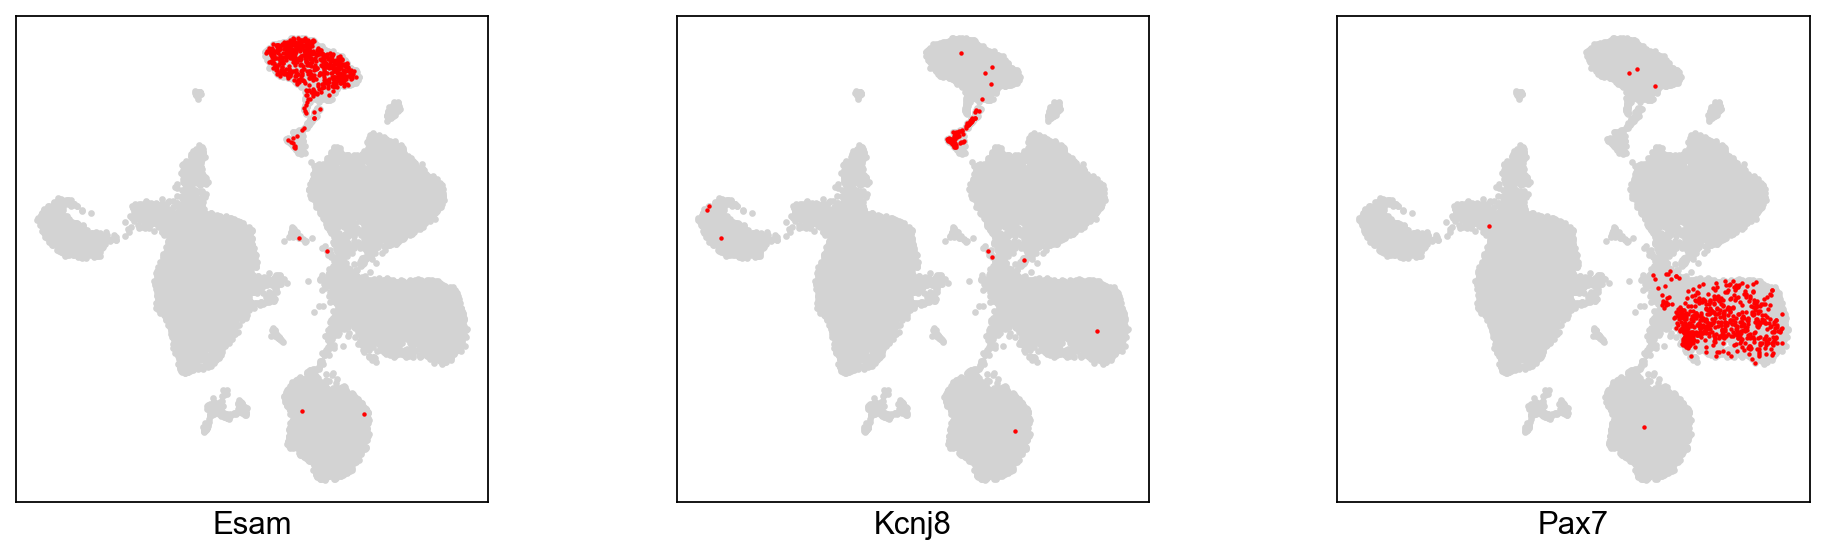

In [73]:
import matplotlib.pyplot as plt
from matplotlib import rc_context

with rc_context({'figure.figsize': (15, 4)}):
    print('[Starting umapping]')
    fig, axs = plt.subplots(ncols=3, nrows=1)
    axs = axs.flatten()
    
    for i in range(len(axs)):
        tmp = filter_anndata_by_gene(adata, genes[i], lim=limits[genes[i]])
        
        axs[i].scatter(x=adata.obsm['X_umap'].T[0], y=adata.obsm['X_umap'].T[1], s=4, c="lightgrey")
        axs[i].scatter(x=tmp.obsm['X_umap'].T[0], y=tmp.obsm['X_umap'].T[1], s=1, c="red")
        axs[i].set_xlabel(genes[i])
        
        axs[i].set_xticks([])  # Hide x-axis ticks
        axs[i].set_yticks([])  # Hide y-axis ticks

        axs[i].set_aspect('equal')  # Set aspect ratio to equal
    plt.savefig(os.path.join(sc.settings.figdir, "marker_plot.png"))
    pl.show()
    # plt.close()


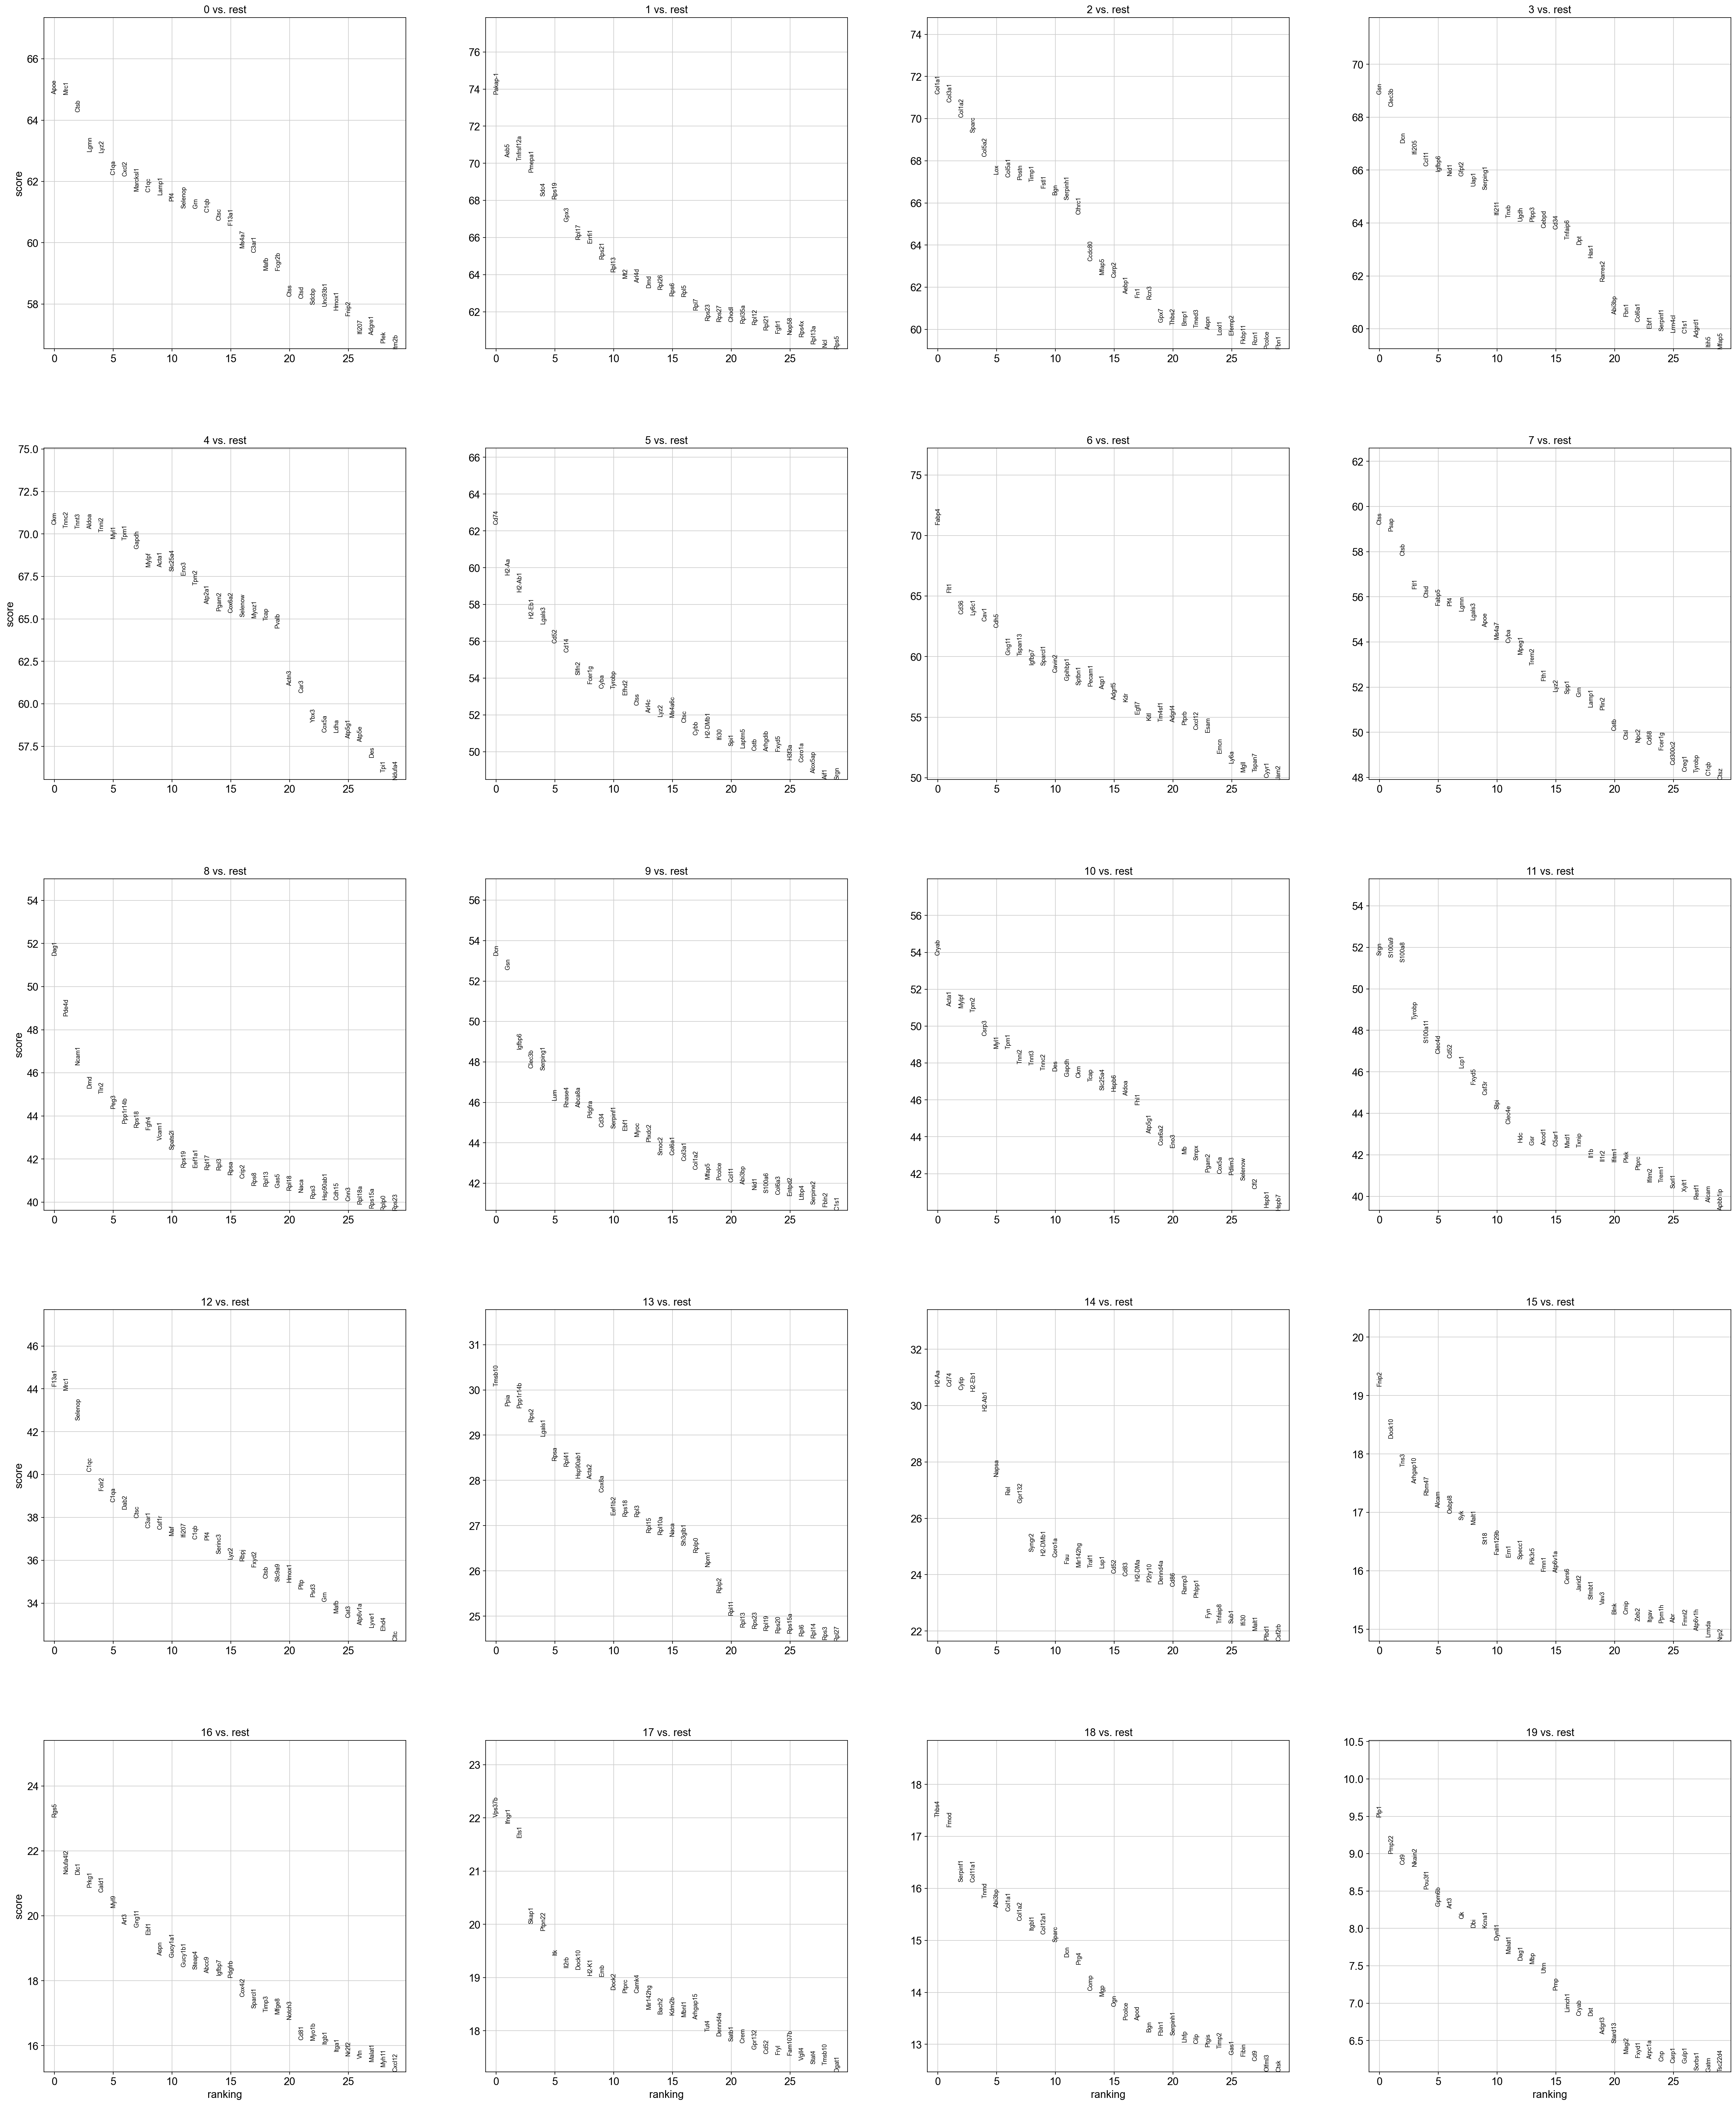

In [63]:
# Find markers/ label cell types

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False, save='rank_genes_groups.png')

In [64]:
result=adata.uns['rank_genes_groups']
groups=result ['names'].dtype.names
df=pd.DataFrame(
    {group + '_' + key[:15]: result [key] [group]
     for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

In [65]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges >1)]
markers

group     names     scores  logfoldchanges     pvals  pvals_adj
0          0      Apoe  64.856285        4.681692  0.000000   0.000000
1          0      Mrc1  64.845474        4.162632  0.000000   0.000000
2          0      Ctsb  64.269707        3.319763  0.000000   0.000000
3          0      Lgmn  62.975883        3.821754  0.000000   0.000000
4          0      Lyz2  62.949558        4.810913  0.000000   0.000000
...      ...       ...        ...             ...       ...        ...
390458    19   Col20a1   3.367301        6.085127  0.000759   0.044168
390459    19     Srsf7   3.365425        1.273350  0.000764   0.044344
390460    19    Mboat2   3.357744        4.971389  0.000786   0.045212
390461    19  Ppp1r14c   3.353637        3.373150  0.000798   0.045633
390462    19      Nfia   3.332722        1.349255  0.000860   0.048595

[24265 rows x 6 columns]

In [66]:
# Create a DataFrame from the 'markers' variable
markersnew9_df = pd.DataFrame(markers)

# Define the full path including the file name and extension
csv_file_path = 'Y:/Tolulope/Cellranger Results/YYY/markers_output.csv'

# Save the DataFrame to a CSV file
markersnew9_df.to_csv(csv_file_path, index=False)

print(f"Output saved to {csv_file_path}")

Output saved to Y:/Tolulope/Cellranger Results/YYY/markers_output.csv


In [73]:
cell_type = {
    "0": "Monocytes/Macrophages",
    "1": "Fibroadipogenic cells",
    "2": "Mature Skeletal muscle",
    "3": "MuSCs and progenitors",
    "4": "MuSCs and Myoblasts",
    "5": "Myo-Fibroblast",
    "6": "Endothelial cells",
    "7": "Anti-inflammatory Macrophages",
    "8": "Neutrophils",
    "9": "Residence Macrophages/APC I",
    "10": "Residence Macrophages/APC II",
    "11": "Proliferation",
    "12": "T-lymphocytes and NKCs",
    "13": "Pericyte cells", 
    "14": "Tenocyte",
    "15": "Schwann cells",
    
        
}

In [95]:
cell_type = {
    "0": "Mature Skeletal muscle",
    "1": "Anti-inflammatory Macrophages II",
    "2": "MuSCs and Myoblasts",
    "3": "Myo-Fibroblast",
    "4": "Fibroadipogenic cells II",
    "5": "Monocytes/Macrophages",
    "6": "MuSCs and progenitors",
    "7": "Endothelial cells",
    "8": "Residence Macrophages/APC II",
    "9": "Fibroadipogenic cells I",
    "10": "Neutrophils",
    "11": "Anti-inflammatory Macrophages I",
    "12": "Residence Macrophages/APC I",
    "13": "Proliferation",
    "14": "Pericyte cells", 
    "15": "T-lymphocytes and NKCs",
    "16": "Tenocyte",
    "17": "Schwann cells",
  
        
}

In [74]:
cell_type = {
    "0": "Anti-inflammatory Macrophages II",
    "1":"MuSCs and Myoblasts",
    "2": "Myo-Fibroblast",
    "3": "Fibroadipogenic cells II",
    "4": "Type IIB myofibers",
    "5": "Residence Macrophages/APC II",
    "6": "Endothelial cells",
    "7": "Monocytes/Macrophages",
    "8": "MuSCs and progenitors",
    "9": "Fibroadipogenic cells I",
    "10": "Type IIA myofibers",
    "11": "Neutrophils",
    "12": "Anti-inflammatory Macrophages I",
    "13": "MuSCs and Myocyte",
    "14": "Residence Macrophages/APC I",
    "15": "Proliferation",
    "16": "Pericyte cells",
    "17": "T-lymphocytes and NKCs",
    "18": "Tenocyte",
    "19": "Schwann cells",
  
        
}

In [73]:
markers[markers.names =='Myh2']

group names     scores  logfoldchanges          pvals      pvals_adj
205494    10  Myh2  24.580671        7.438285  2.033380e-133  8.334562e-132

In [ ]:
cell_type = {
    "0": "Mature Skeletal muscle",
    "1": "Fibroadipogenic cells 1",
    "2": "Myo-Fibroblast",
    "3": "Monocytes/Macrophages",
    "4": "MuSCs and progenitors",
    "5": "MuSCs and Myoblasts",
    "6": "Anti-inflammatory Macrophages 1",
    "7": "Endothelial cells",
    "8": "Residence Macrophages/APC",
    "9": "Neutrophils",
    "10": "Anti-inflammatory Macrophages 2",
    "11": "Fibroadipogenic cells 2",
    "12": "Proliferation",
    "13": "B cells/Residence Macrophages/APC",
    "14": "T-lymphocytes and NKCs",
    "15": "Pericyte cells", 
    "16": "Tenocyte",
    "17": "Schwann cells",
    "18": "Lymphatic endothelial cells",
        
}

In [ ]:
#cell_type = {"0":"Fibroblast Pdgfra, Gsn, Lum, Col6a2 ",
"1":" MuSCs and Myoblasts Myod1, Pax7, Sdc4,   Myf5",    Asb5 Dmd
"2":"Endothelial cells Pecam1, Cldn5, Vwf, Emcn, Flt1, Flt4 Egfl7 Fabp4"
"3":"Anti-inflammatory Macrophages/Monocyte cells  C1qa, Apoe, Cd14, Aif1 "
"4":"Monocytes/macrophages/Platelet Cd68, Pf4, Cd38,Ms4a7, Cd86, Lyz2, Cd14, Cfp",     Mrc1(7)
"5":"Type IIB fiber Myh4, Actn3 Myh1, Acta1,Tnnc2",
"6":"Type IIA fiber Myh2, Myh1, Acta1, Tnnc2, Actn3",
"7":"Neutrophils S100a9, S100a8, Ly6g, Trem1",
"8":"Activated MuSCs and myogenic progenitor cells Pax7 Vcam1, Myf5, Myog",
"9":"M2 Macrophages Cd163, Lyve1, Mrc1, Folr2, Fcna, Egr2", Bank1, Cd33
"10":"Proinflamatory Macrophage/Monocyte cells  Ccl6 Cd14, Ccr2, Cd80 Il1b, Mefv",
"11":"Residence M1 Macrophages/APC Cd74, H2-Ab1, H2-Aa, H2-Eb1, H2-DMb1, Cd80, Cd86, Cd40, Tpm3,Myl6", 
"12":"Proliferating immune cells Cenpe, Cenpe, Top2a, Tk1, Tyms, Ube2c Birc5, Stmn1",
"13":"B- and T-lymphocytes and Natural killer cells Cd3d, Cd3e,  Ccl5,  Nkg7, Tbx21,Ptprc,, Skap1 Cd3e, Ikzf1, Il7r, Il2rb,Gata3 ",
"14":"Proliferating macropgages Top2a, Birc5 Pparg, Stmn1, Myo1f, Mpl,     Myh11
"15":"Pericyte cells Rgs5,Kcnj8, Acta2, Mcam, Notch3, Pdgfrb, Cspg4",
"16":"Myo-Fibroblast Cthrc1, Col1a1 Col3a1,", Prg4
"17":"Tenocyte Mkx, Fmod, Tnmd, Scx, Pdgfrb,",
"18":"Bcells Igkc, Ly6d, Cd79a, Cd79b, Pax5, Ighm, Bank1",
"19":"Schwann cell Plp1, Cdh19, Mpz, Kcna1",
"20":"Endothelial cells Pecam1, Cldn5, Vwf, Flt4 Egfl7" Lyve1

#}

In [75]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

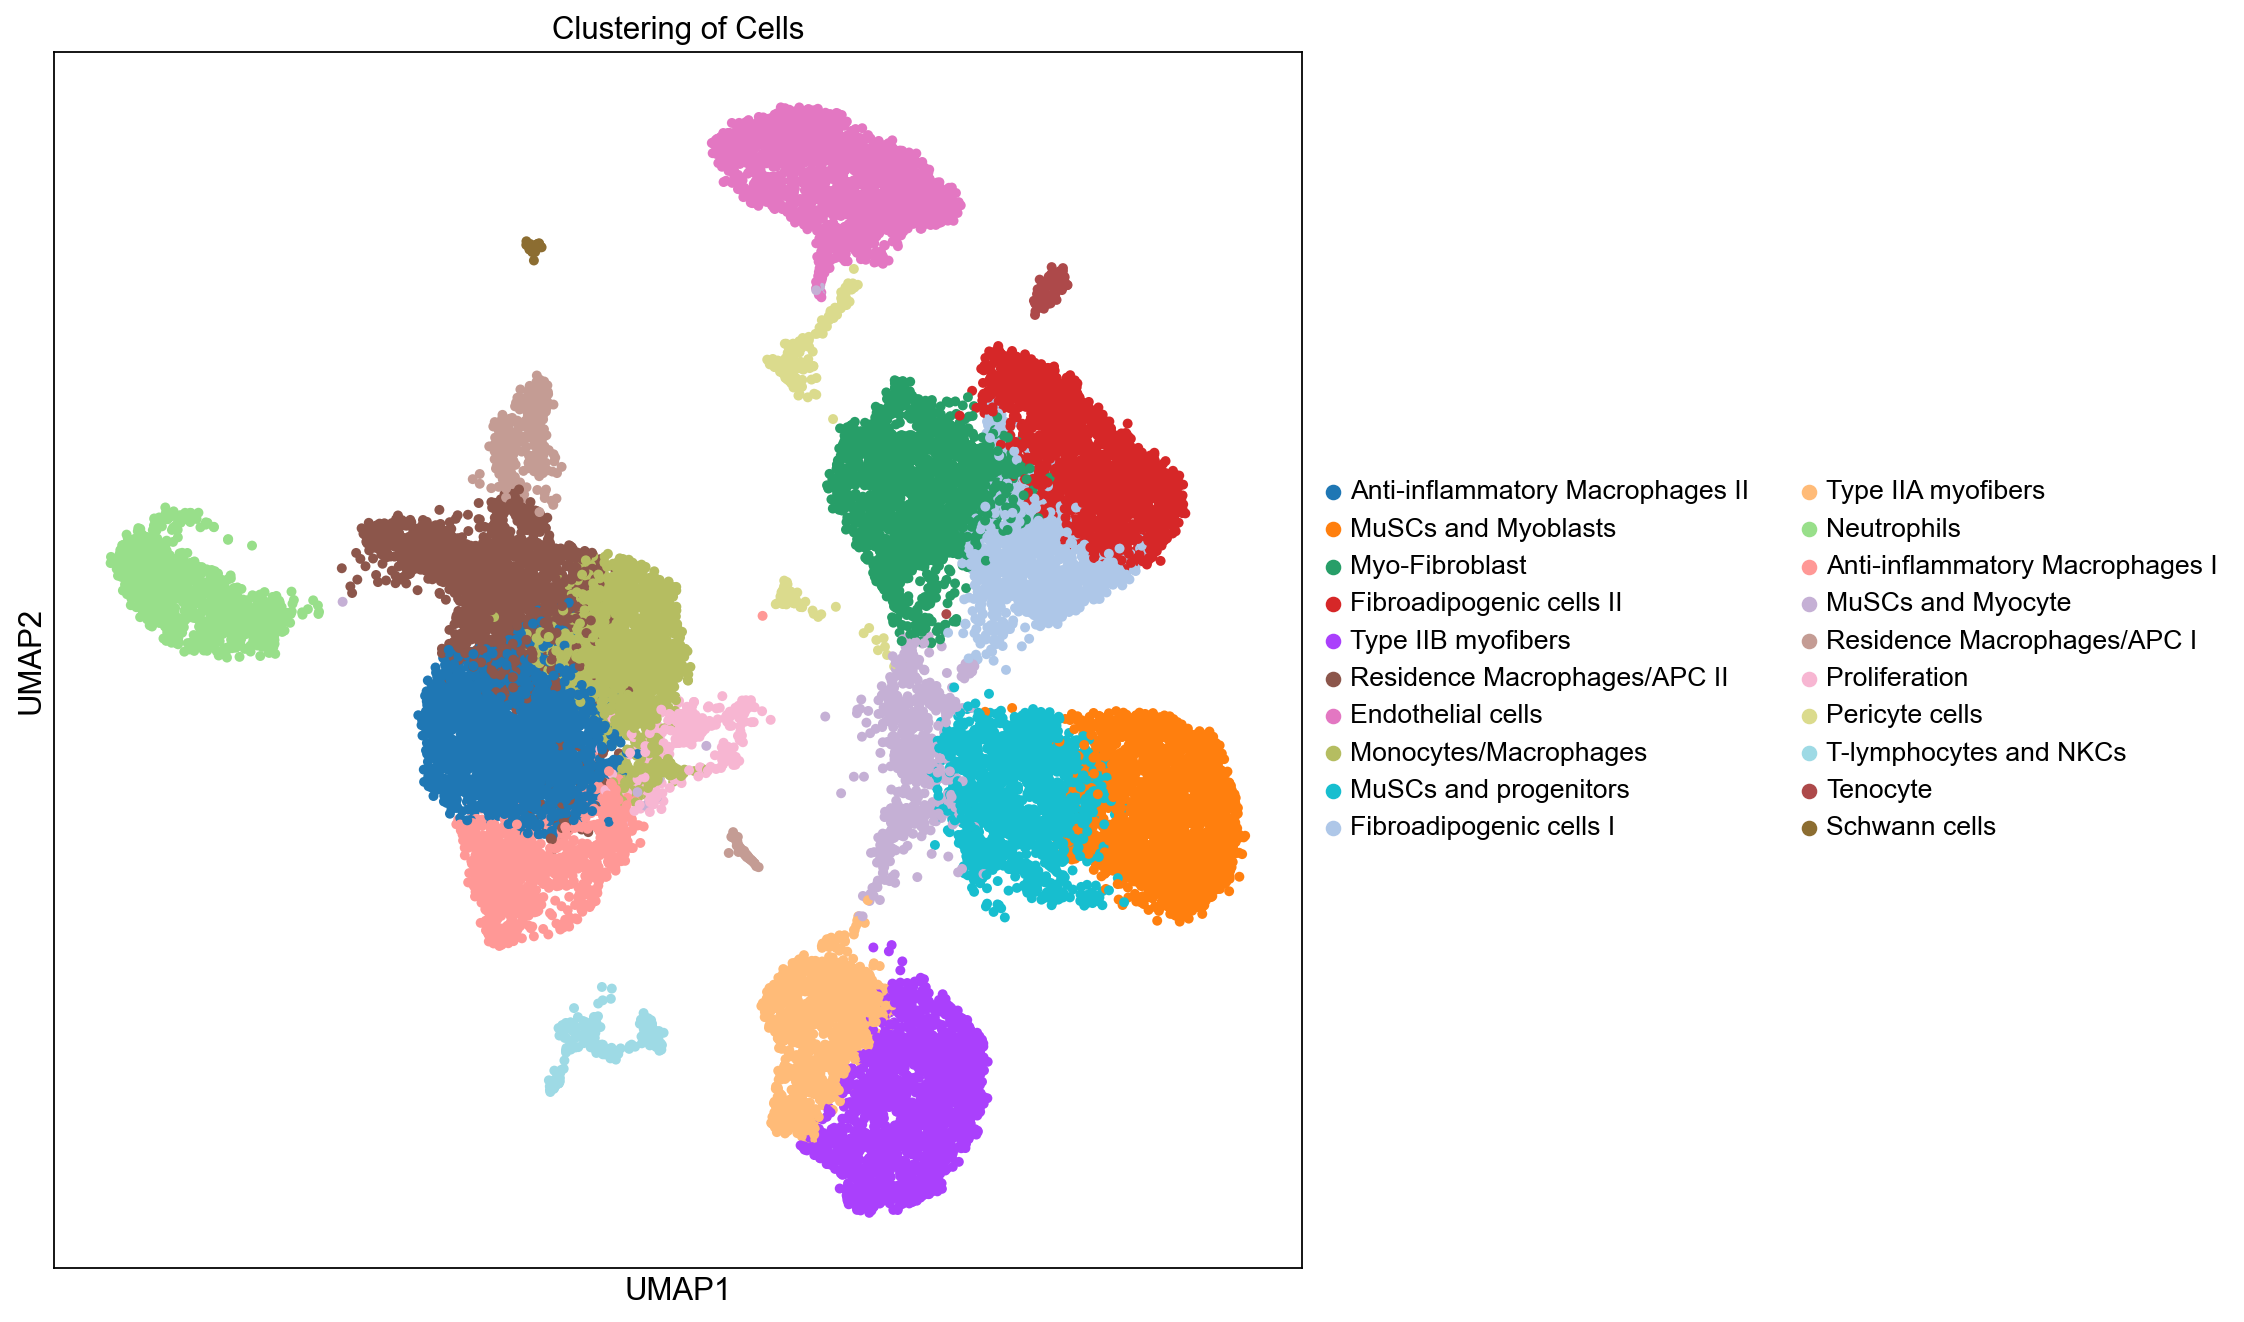

In [76]:
#UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['cell type'],  legend_fontsize=12, legend_fontoutline=2, frameon=True, size=80, title='Clustering of Cells', save=f'umap_plot{img_tag}.png')
pl.show()

In [77]:
adata.obs['batch'].unique().tolist()

['Sham_GFP', 'Sham_noGFP', 'OV_GFP', 'OV_noGFP']

In [78]:
def map_condition(x):
    if 'Sham_GFP' in x:
        return 'Sham_GFP'
    elif 'Sham_noGFP' in x:
        return 'Sham_noGFP'
    elif 'OV_GFP' in x:
        return 'OV_GFP'
    else:
        return 'OV_noGFP'

adata.obs['condition'] = adata.obs.batch.map(map_condition)
adata.obs


n_genes  n_genes_by_counts  total_counts  \
AAACCCAGTTCCGTTC-1-Sham_GFP     4116               4116       15405.0   
AAACCCATCCATACTT-1-Sham_GFP     2850               2850       10036.0   
AAACCCATCCCACAGG-1-Sham_GFP     2414               2414        7717.0   
AAACGAACATACCACA-1-Sham_GFP     2668               2668        9444.0   
AAACGAAGTCGTGGTC-1-Sham_GFP     2716               2716        9703.0   
...                              ...                ...           ...   
TTTGTTGAGATGGCGT-1-OV_noGFP     1873               1873        4125.0   
TTTGTTGCACCGAATT-1-OV_noGFP     4590               4590       23666.0   
TTTGTTGCATCCTTCG-1-OV_noGFP     3014               3014       10031.0   
TTTGTTGGTCAGGAGT-1-OV_noGFP     1780               1780        4392.0   
TTTGTTGGTTGTGCAT-1-OV_noGFP     2986               2986        8995.0   

                             total_counts_mt  pct_counts_mt  doublet_score  \
AAACCCAGTTCCGTTC-1-Sham_GFP            653.0       4.238883       0.274809   
AAACCCATCCATACTT-1-Sham_GFP            417.0       4.155042       0.084986   
AAACCCATCCCACAGG-1-Sham_GFP            212.0       2.747182       0.136364   
AAACGAACATACCACA-1-Sham_GFP            274.0       2.901313       0.136364   
AAACGAAGTCGTGGTC-1-Sham_GFP            588.0       6.059981       0.091181   
...                                      ...            ...            ...   
TTTGTTGAGATGGCGT-1-OV_noGFP            218.0       5.284848       0.017241   
TTTGTTGCACCGAATT-1-OV_noGFP            426.0       1.800051       0.041409   
TTTGTTGCATCCTTCG-1-OV_noGFP            198.0       1.973881       0.040225   
TTTGTTGGTCAGGAGT-1-OV_noGFP             67.0       1.525501       0.057851   
TTTGTTGGTTGTGCAT-1-OV_noGFP            427.0       4.747082       0.037975   

                             predicted_doublet     batch leiden  \
AAACCCAGTTCCGTTC-1-Sham_GFP              False  Sham_GFP      6   
AAACCCATCCATACTT-1-Sham_GFP              False  Sham_GFP      1   
AAACCCATCCCACAGG-1-Sham_GFP              False  Sham_GFP      1   
AAACGAACATACCACA-1-Sham_GFP              False  Sham_GFP      1   
AAACGAAGTCGTGGTC-1-Sham_GFP              False  Sham_GFP      1   
...                                        ...       ...    ...   
TTTGTTGAGATGGCGT-1-OV_noGFP              False  OV_noGFP      7   
TTTGTTGCACCGAATT-1-OV_noGFP              False  OV_noGFP     12   
TTTGTTGCATCCTTCG-1-OV_noGFP              False  OV_noGFP      7   
TTTGTTGGTCAGGAGT-1-OV_noGFP              False  OV_noGFP     12   
TTTGTTGGTTGTGCAT-1-OV_noGFP              False  OV_noGFP      0   

                                                    cell type condition  
AAACCCAGTTCCGTTC-1-Sham_GFP                 Endothelial cells  Sham_GFP  
AAACCCATCCATACTT-1-Sham_GFP               MuSCs and Myoblasts  Sham_GFP  
AAACCCATCCCACAGG-1-Sham_GFP               MuSCs and Myoblasts  Sham_GFP  
AAACGAACATACCACA-1-Sham_GFP               MuSCs and Myoblasts  Sham_GFP  
AAACGAAGTCGTGGTC-1-Sham_GFP               MuSCs and Myoblasts  Sham_GFP  
...                                                       ...       ...  
TTTGTTGAGATGGCGT-1-OV_noGFP             Monocytes/Macrophages  OV_noGFP  
TTTGTTGCACCGAATT-1-OV_noGFP   Anti-inflammatory Macrophages I  OV_noGFP  
TTTGTTGCATCCTTCG-1-OV_noGFP             Monocytes/Macrophages  OV_noGFP  
TTTGTTGGTCAGGAGT-1-OV_noGFP   Anti-inflammatory Macrophages I  OV_noGFP  
TTTGTTGGTTGTGCAT-1-OV_noGFP  Anti-inflammatory Macrophages II  OV_noGFP  

[23451 rows x 11 columns]

In [79]:
adata.write_h5ad('integrated young29.h5ad')

In [80]:
# Cell counting
adata.obs.groupby(['batch']).count()

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
batch                                                                   
Sham_GFP       2563               2563          2563             2563   
Sham_noGFP     7866               7866          7866             7866   
OV_GFP         4653               4653          4653             4653   
OV_noGFP       8369               8369          8369             8369   

            pct_counts_mt  doublet_score  predicted_doublet  leiden  \
batch                                                                 
Sham_GFP             2563           2563               2563    2563   
Sham_noGFP           7866           7866               7866    7866   
OV_GFP               4653           4653               4653    4653   
OV_noGFP             8369           8369               8369    8369   

            cell type  condition  
batch                             
Sham_GFP         2563       2563  
Sham_noGFP       7866       7866  
OV_GFP           4653       4653  
OV_noGFP         8369       8369

In [81]:
num_tot_cells = adata.obs.groupby(['batch']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.n_genes))
num_tot_cells

{'Sham_GFP': 2563, 'Sham_noGFP': 7866, 'OV_GFP': 4653, 'OV_noGFP': 8369}

In [82]:
cell_type_counts = adata.obs.groupby(['batch', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()

cell_type_counts

batch condition                         cell type  n_genes  \
0   Sham_GFP  Sham_GFP  Anti-inflammatory Macrophages II       18   
1   Sham_GFP  Sham_GFP               MuSCs and Myoblasts     1845   
2   Sham_GFP  Sham_GFP                    Myo-Fibroblast       28   
3   Sham_GFP  Sham_GFP          Fibroadipogenic cells II       24   
4   Sham_GFP  Sham_GFP                Type IIB myofibers       37   
..       ...       ...                               ...      ...   
72  OV_noGFP  OV_noGFP                     Proliferation      191   
73  OV_noGFP  OV_noGFP                    Pericyte cells       66   
74  OV_noGFP  OV_noGFP            T-lymphocytes and NKCs      157   
75  OV_noGFP  OV_noGFP                          Tenocyte       25   
76  OV_noGFP  OV_noGFP                     Schwann cells       11   

    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                  18            18               18             18   
1                1845          1845             1845           1845   
2                  28            28               28             28   
3                  24            24               24             24   
4                  37            37               37             37   
..                ...           ...              ...            ...   
72                191           191              191            191   
73                 66            66               66             66   
74                157           157              157            157   
75                 25            25               25             25   
76                 11            11               11             11   

    doublet_score  predicted_doublet  leiden  
0              18                 18      18  
1            1845               1845    1845  
2              28                 28      28  
3              24                 24      24  
4              37                 37      37  
..            ...                ...     ...  
72            191                191     191  
73             66                 66      66  
74            157                157     157  
75             25                 25      25  
76             11                 11      11  

[77 rows x 11 columns]

In [83]:
cell_type_counts['total_cells'] = cell_type_counts.batch.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.n_genes / cell_type_counts.total_cells

cell_type_counts

batch condition                         cell type  n_genes  \
0   Sham_GFP  Sham_GFP  Anti-inflammatory Macrophages II       18   
1   Sham_GFP  Sham_GFP               MuSCs and Myoblasts     1845   
2   Sham_GFP  Sham_GFP                    Myo-Fibroblast       28   
3   Sham_GFP  Sham_GFP          Fibroadipogenic cells II       24   
4   Sham_GFP  Sham_GFP                Type IIB myofibers       37   
..       ...       ...                               ...      ...   
72  OV_noGFP  OV_noGFP                     Proliferation      191   
73  OV_noGFP  OV_noGFP                    Pericyte cells       66   
74  OV_noGFP  OV_noGFP            T-lymphocytes and NKCs      157   
75  OV_noGFP  OV_noGFP                          Tenocyte       25   
76  OV_noGFP  OV_noGFP                     Schwann cells       11   

    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                  18            18               18             18   
1                1845          1845             1845           1845   
2                  28            28               28             28   
3                  24            24               24             24   
4                  37            37               37             37   
..                ...           ...              ...            ...   
72                191           191              191            191   
73                 66            66               66             66   
74                157           157              157            157   
75                 25            25               25             25   
76                 11            11               11             11   

    doublet_score  predicted_doublet  leiden  total_cells  frequency  
0              18                 18      18         2563   0.007023  
1            1845               1845    1845         2563   0.719860  
2              28                 28      28         2563   0.010925  
3              24                 24      24         2563   0.009364  
4              37                 37      37         2563   0.014436  
..            ...                ...     ...          ...        ...  
72            191                191     191         8369   0.022822  
73             66                 66      66         8369   0.007886  
74            157                157     157         8369   0.018760  
75             25                 25      25         8369   0.002987  
76             11                 11      11         8369   0.001314  

[77 rows x 13 columns]

<Figure size 960x640 with 0 Axes>

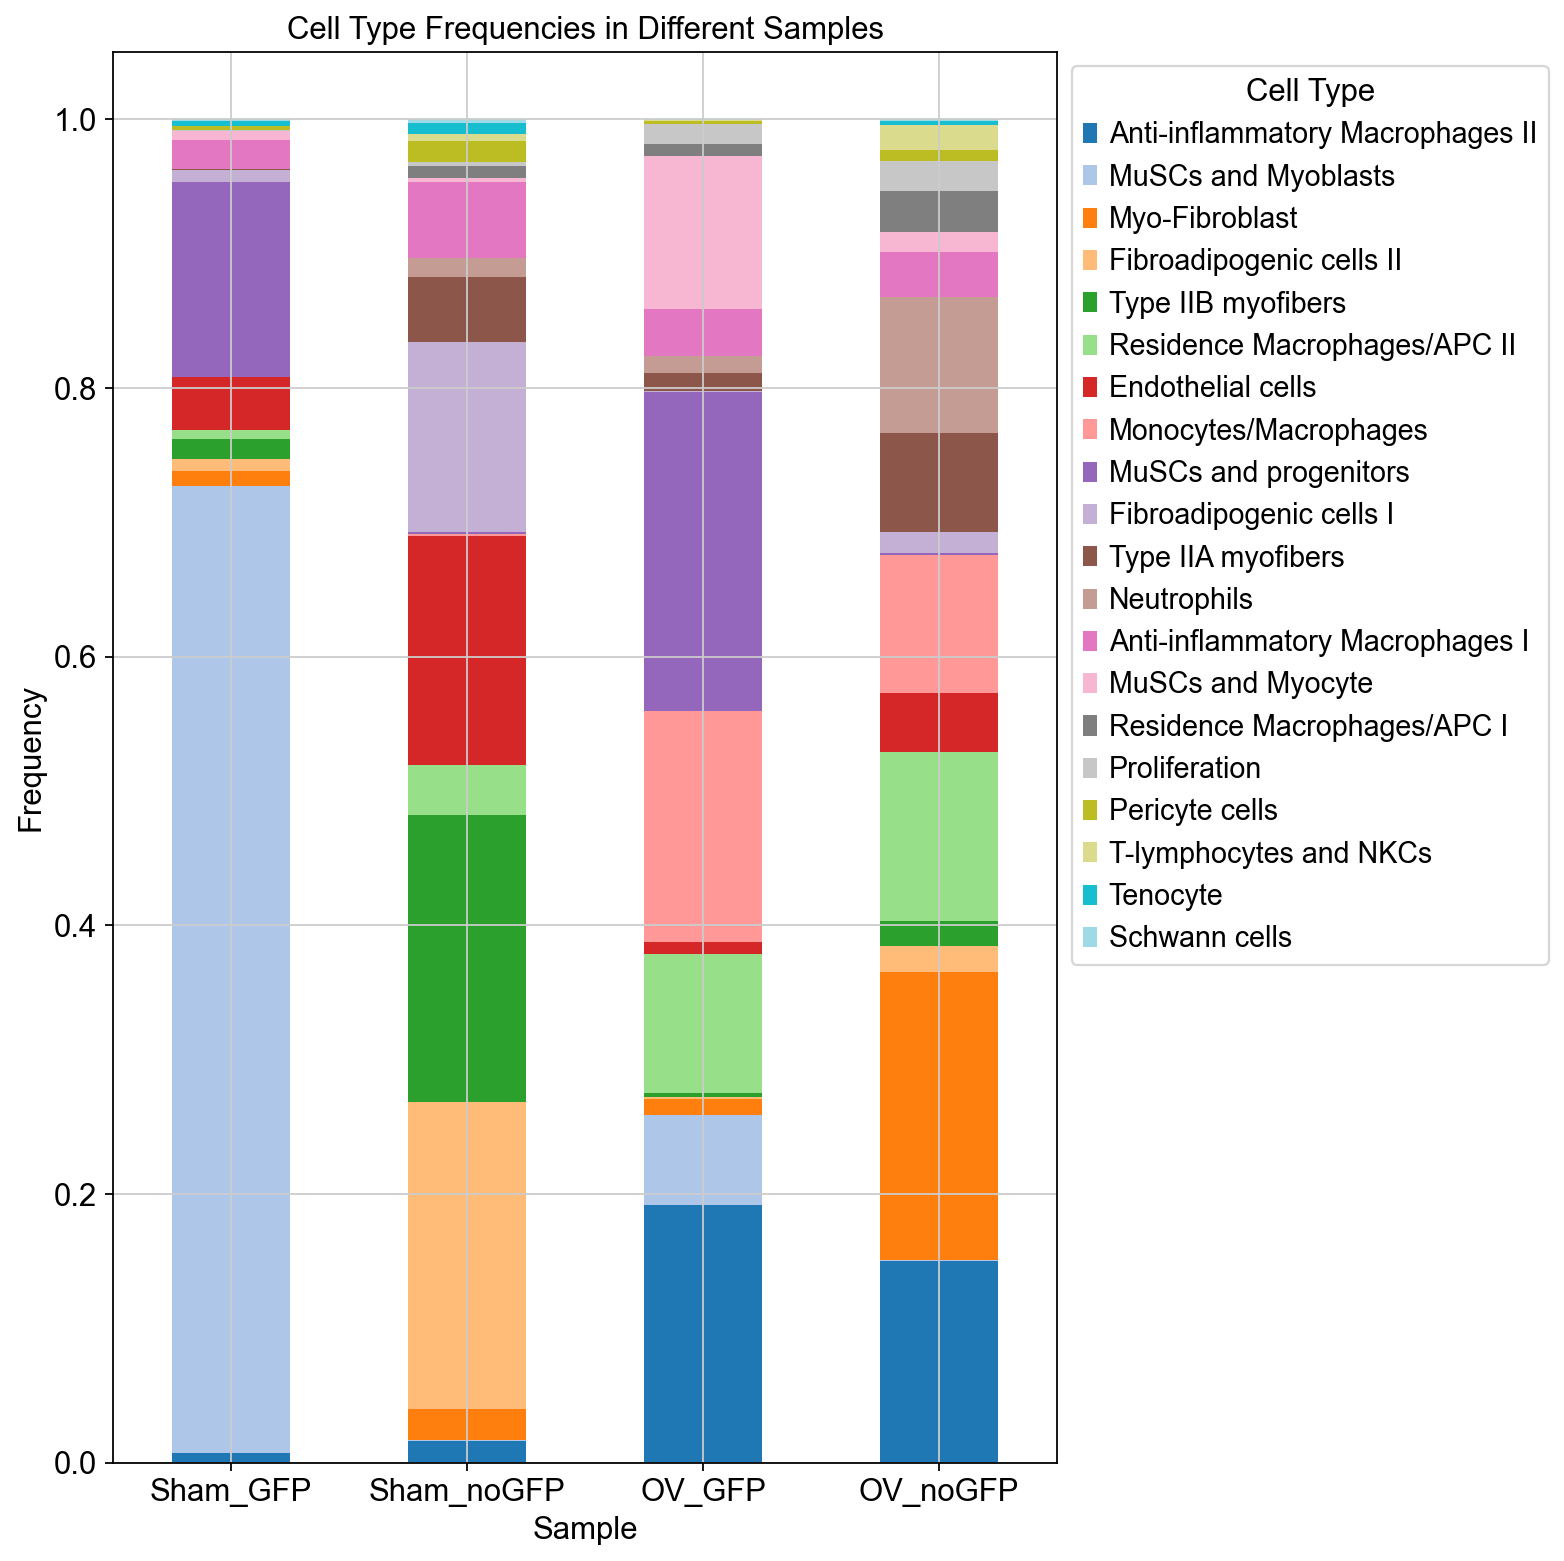

In [84]:
# Filter cell_type_counts to include only relevant columns
cell_type_counts = cell_type_counts[['batch', 'condition', 'cell type', 'frequency']]

# Set the figure size
pl.figure(figsize=(12, 8))

# Define the order of samples in the plot
sample_order = ['Sham_GFP', 'Sham_noGFP', 'OV_GFP', 'OV_noGFP']

# Filter data for the specified samples
filtered_data = cell_type_counts[cell_type_counts['condition'].isin(sample_order)]

# Pivot the DataFrame for a stacked bar plot
stacked_data = filtered_data.pivot_table(index='condition', columns='cell type', values='frequency', fill_value=0)

# Create a stacked bar plot with distinct colors for each cell type
stacked_data.plot(kind='bar', stacked=True, colormap='tab20')

# Set plot properties
pl.xticks(rotation=0)  # Keep the x-axis labels horizontal
pl.xlabel('Sample')
pl.ylabel('Frequency')
pl.legend(title='Cell Type', bbox_to_anchor=(1, 1))  # Move the legend outside the plot area
pl.title('Cell Type Frequencies in Different Samples')
pl.tight_layout()
pl.savefig('bar99_plot.png')
# Show the plot
pl.show()

In [86]:
# Calculate percentages for each cell type across groups
percentage_data = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100
# Export percentages to a CSV file
percentage_data.to_csv('cell_type_percentages new99.csv', index=True)


In [18]:
# Read the 10x Genomics data into AnnData objects
adata1 = sc.read_10x_mtx(Sham_GFP, var_names='gene_symbols', cache=True)
adata2 = sc.read_10x_mtx(Sham_noGFP, var_names='gene_symbols', cache=True)
adata3 = sc.read_10x_mtx(OV_GFP, var_names='gene_symbols', cache=True)
adata4 = sc.read_10x_mtx(OV_noGFP, var_names='gene_symbols', cache=True)

In [18]:
# Define erythroid genes
erythroid_genes = ['Hba-a1', 'Hba-a2', 'Hbb-bs', 'Hbb-bt', 'Alas2']

# Function to filter cells based on erythroid gene expression
def filter_erythroid_genes(adata):
    adata.obs['pct_erythroid'] = (adata[:, erythroid_genes].X.sum(axis=1) / adata.X.sum(axis=1)) * 100
    adata = adata[adata.obs['pct_erythroid'] <= 1]
    return adata

# Apply erythroid gene filtering
for adata in [adata1, adata2, adata3, adata4]:
    adata = filter_erythroid_genes(adata)


In [19]:
# Make variable names unique
for adata in [adata1, adata2, adata3, adata4]:
    adata.var_names_make_unique()

# Save raw data
for adata in [adata1, adata2, adata3, adata4]:
    adata.raw = adata

# Annotate mitochondrial genes
for adata in [adata1, adata2, adata3, adata4]:
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # Assuming mitochondrial genes start with 'MT-'
    adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl")) # ribosomal genes

In [20]:
# Calculate ribosomal counts
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)


In [21]:
# Calculate QC metrics
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


In [6]:
# Make variable names unique
for adata in [adata1, adata2, adata3, adata4]:
    adata.var_names_make_unique()

# Save raw data
for adata in [adata1, adata2, adata3, adata4]:
    adata.raw = adata

# Annotate mitochondrial genes
for adata in [adata1, adata2, adata3, adata4]:
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # Assuming mitochondrial genes start with 'MT-'
    adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl")) # ribosomal genes

# Calculate QC metrics
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells based on QC metrics
for adata in [adata1, adata2, adata3, adata4]:
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 15]


In [7]:
adata1.var.sort_values('n_cells_by_counts')

gene_ids    feature_types     mt   ribo  \
Gm33053   ENSMUSG00000110789  Gene Expression  False  False   
Vmn1r118  ENSMUSG00000094589  Gene Expression  False  False   
Vmn1r119  ENSMUSG00000094010  Gene Expression  False  False   
Vmn1r120  ENSMUSG00000093986  Gene Expression  False  False   
Vmn1r121  ENSMUSG00000094680  Gene Expression  False  False   
...                      ...              ...    ...    ...   
mt-Atp6   ENSMUSG00000064357  Gene Expression   True  False   
mt-Cytb   ENSMUSG00000064370  Gene Expression   True  False   
mt-Co2    ENSMUSG00000064354  Gene Expression   True  False   
mt-Co3    ENSMUSG00000064358  Gene Expression   True  False   
Gm42418   ENSMUSG00000098178  Gene Expression  False  False   

          n_cells_by_counts  mean_counts  pct_dropout_by_counts  total_counts  
Gm33053                   0     0.000000             100.000000           0.0  
Vmn1r118                  0     0.000000             100.000000           0.0  
Vmn1r119                  0     0.000000             100.000000           0.0  
Vmn1r120                  0     0.000000             100.000000           0.0  
Vmn1r121                  0     0.000000             100.000000           0.0  
...                     ...          ...                    ...           ...  
mt-Atp6                2740    65.872200               1.083032      182466.0  
mt-Cytb                2741    44.366787               1.046931      122896.0  
mt-Co2                 2742    44.249458               1.010830      122571.0  
mt-Co3                 2751    73.811554               0.685921      204458.0  
Gm42418                2761    32.502888               0.324910       90033.0  

[32285 rows x 8 columns]

In [17]:
# Quality Control (QC)
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.filter_cells(adata, min_genes=200)
    #sc.pp.filter_genes(adata, min_cells=3)

In [18]:
adata1.var.sort_values('n_cells_by_counts')

gene_ids    feature_types     mt  n_cells_by_counts  \
Gsdmc4         ENSMUSG00000055748  Gene Expression  False                  3   
Gm805          ENSMUSG00000097543  Gene Expression  False                  3   
Gm40477        ENSMUSG00000113940  Gene Expression  False                  3   
F730311O21Rik  ENSMUSG00000100658  Gene Expression  False                  3   
C030017B01Rik  ENSMUSG00000118202  Gene Expression  False                  3   
...                           ...              ...    ...                ...   
mt-Atp6        ENSMUSG00000064357  Gene Expression   True               2740   
mt-Cytb        ENSMUSG00000064370  Gene Expression   True               2741   
mt-Co2         ENSMUSG00000064354  Gene Expression   True               2742   
mt-Co3         ENSMUSG00000064358  Gene Expression   True               2751   
Gm42418        ENSMUSG00000098178  Gene Expression  False               2761   

               mean_counts  pct_dropout_by_counts  total_counts  n_cells  
Gsdmc4            0.001444              99.891697           4.0        3  
Gm805             0.001444              99.891697           4.0        3  
Gm40477           0.001083              99.891697           3.0        3  
F730311O21Rik     0.001083              99.891697           3.0        3  
C030017B01Rik     0.001083              99.891697           3.0        3  
...                    ...                    ...           ...      ...  
mt-Atp6          65.872200               1.083032      182466.0     2731  
mt-Cytb          44.366787               1.046931      122896.0     2732  
mt-Co2           44.249458               1.010830      122571.0     2733  
mt-Co3           73.811554               0.685921      204458.0     2742  
Gm42418          32.502888               0.324910       90033.0     2754  

[17684 rows x 8 columns]

In [19]:
adata1.obs.sort_values('total_counts')

n_genes_by_counts  total_counts  total_counts_mt  \
ATTTCACCATGAATCC-1                261         500.0             15.0   
CGTAATGAGTTCCATG-1                291         503.0            172.0   
CAATGACGTGACACGA-1                311         515.0              1.0   
ACATTTCTCAGCTTGA-1                247         528.0              2.0   
TCGTGGGAGTTACGGG-1                338         530.0             42.0   
...                               ...           ...              ...   
TTGTTGTCAATCGCCG-1               3964       41471.0             12.0   
TTTAGTCCACACGGTC-1               5242       41998.0            555.0   
TACAGGTAGCAAGTGC-1               5926       42097.0            842.0   
GCATGATCACAGTGTT-1               6631       50008.0           1192.0   
AATCGACTCGTTCTCG-1               8219       72210.0           1336.0   

                    pct_counts_mt  n_genes  
ATTTCACCATGAATCC-1       3.000000      261  
CGTAATGAGTTCCATG-1      34.194832      291  
CAATGACGTGACACGA-1       0.194175      311  
ACATTTCTCAGCTTGA-1       0.378788      246  
TCGTGGGAGTTACGGG-1       7.924529      337  
...                           ...      ...  
TTGTTGTCAATCGCCG-1       0.028936     3955  
TTTAGTCCACACGGTC-1       1.321491     5233  
TACAGGTAGCAAGTGC-1       2.000142     5916  
GCATGATCACAGTGTT-1       2.383619     6623  
AATCGACTCGTTCTCG-1       1.850159     8201  

[2761 rows x 5 columns]

In [20]:
adata1.X.sum(axis=1)

matrix([[15404.],
        [10036.],
        [ 7715.],
        ...,
        [ 7794.],
        [ 6699.],
        [ 6979.]], dtype=float32)

In [23]:
# Normalize total counts and log-transform the data
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Assign normalized data to .raw attribute
    adata.raw = adata.copy()

In [24]:
adata1.X.sum(axis=1)

matrix([[4761.8667],
        [4077.4595],
        [3791.703 ],
        ...,
        [3692.6216],
        [3717.6885],
        [3708.8135]], dtype=float32)

In [25]:
# Perform highly variable genes identification
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_bins=20, n_top_genes=2000)


In [26]:
adata1.var

gene_ids    feature_types     mt  n_cells_by_counts  \
Xkr4            ENSMUSG00000051951  Gene Expression  False                 29   
Gm19938         ENSMUSG00000102331  Gene Expression  False                  3   
Rp1             ENSMUSG00000025900  Gene Expression  False                  5   
Sox17           ENSMUSG00000025902  Gene Expression  False                 56   
Mrpl15          ENSMUSG00000033845  Gene Expression  False                466   
...                            ...              ...    ...                ...   
CAAA01118383.1  ENSMUSG00000063897  Gene Expression  False                539   
Vamp7           ENSMUSG00000051412  Gene Expression  False                293   
Tmlhe           ENSMUSG00000079834  Gene Expression  False                123   
CAAA01147332.1  ENSMUSG00000095742  Gene Expression  False                110   
AC149090.1      ENSMUSG00000095041  Gene Expression  False                167   

                mean_counts  pct_dropout_by_counts  total_counts  n_cells  \
Xkr4               0.016606              98.953069          46.0       29   
Gm19938            0.001083              99.891697           3.0        3   
Rp1                0.004693              99.819495          13.0        5   
Sox17              0.048375              97.978339         134.0       56   
Mrpl15             0.201444              83.176895         558.0      466   
...                     ...                    ...           ...      ...   
CAAA01118383.1     0.251625              80.541516         697.0      539   
Vamp7              0.123827              89.422383         343.0      293   
Tmlhe              0.050181              95.559567         139.0      123   
CAAA01147332.1     0.041877              96.028881         116.0      110   
AC149090.1         0.066426              93.971119         184.0      167   

                highly_variable     means  dispersions  dispersions_norm  
Xkr4                      False  0.033138     1.481234          0.249805  
Gm19938                   False  0.003775     1.257996         -0.281505  
Rp1                        True  0.007560     2.099009          1.720118  
Sox17                      True  0.104896     2.246447          2.071021  
Mrpl15                    False  0.433844     1.588134          0.719260  
...                         ...       ...          ...               ...  
CAAA01118383.1            False  0.484334     1.283269         -0.237831  
Vamp7                     False  0.263175     1.224588         -0.776599  
Tmlhe                     False  0.126287     1.404656          0.067548  
CAAA01147332.1            False  0.099319     1.148790         -0.541417  
AC149090.1                False  0.176553     1.708048          0.884756  

[17684 rows x 12 columns]

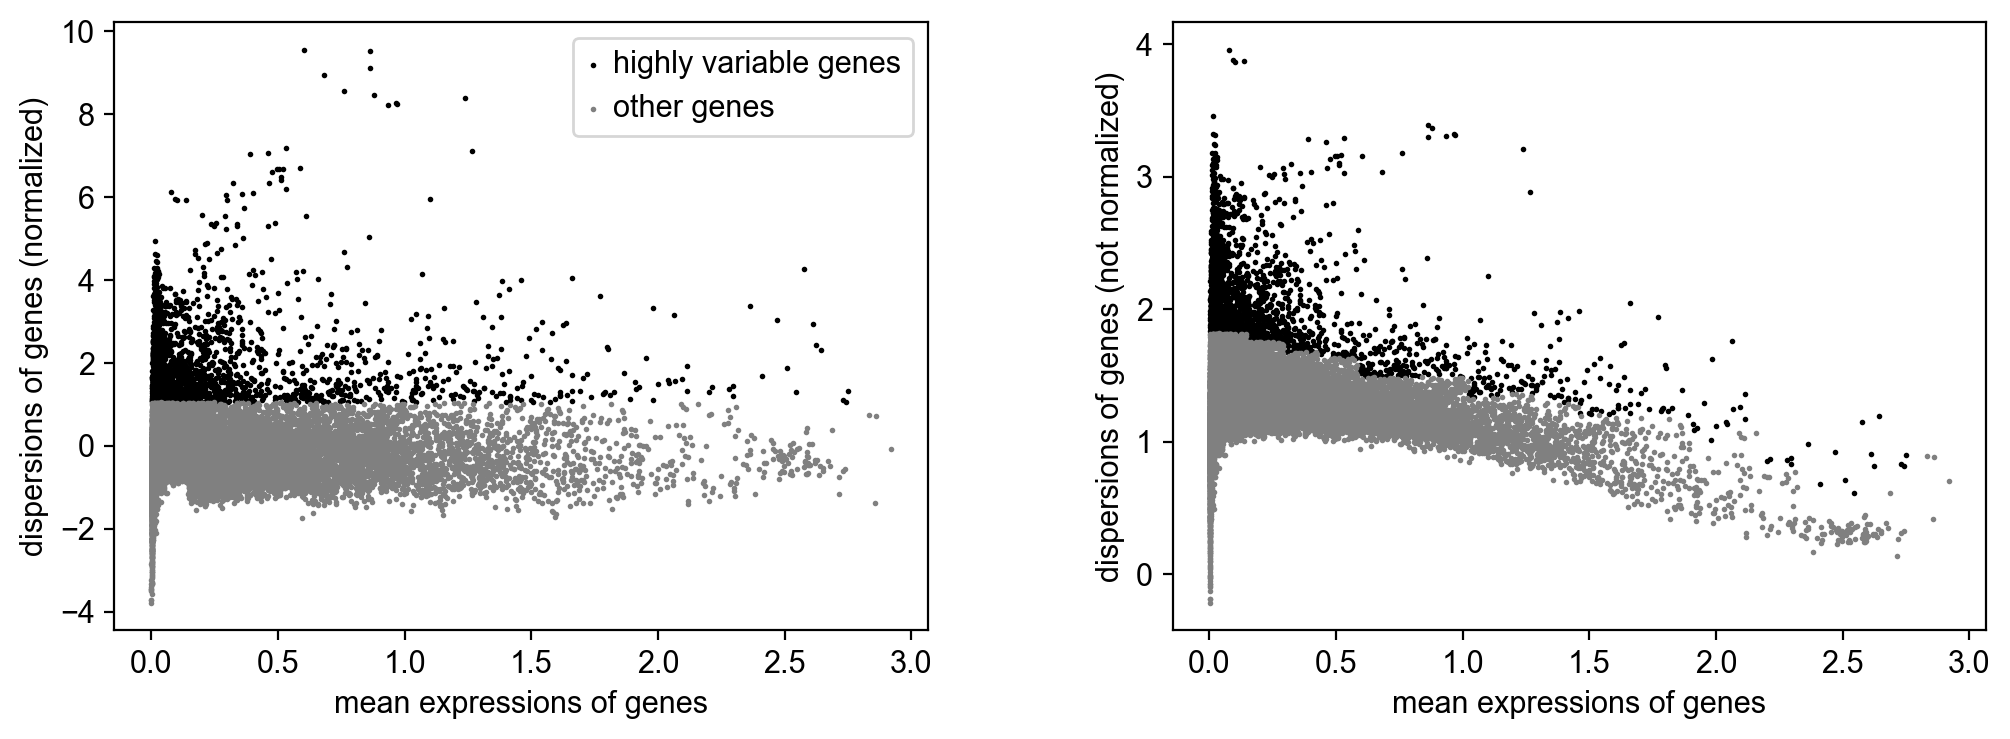

In [28]:
sc.pl.highly_variable_genes(adata1)

In [31]:
# Concatenate normalized datasets into a single AnnData object with batch categories
adata_combined = adata1.concatenate(
    [adata2, adata3, adata4], 
    batch_key=['Sham_GFP', 'Sham_noGFP', 'OV_GFP', 'OV_noGFP']
)


ValueError: Columns must be same length as key

In [28]:
# Perform BBKNN integration
bbknn.bbknn(adata_combined, batch_key="batch")


ValueError: Batch key 'batch' not present in `adata.obs`.